In [1]:
import gpytorch
import torch

from tqdm.autonotebook import tqdm
import numpy as np
import itertools
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
df = pd.read_csv("data.csv")
df

Time post-injection (months) MBSC Region       iM2       iM1       iAI  \
0                              1         NTG  0.014842  0.000000  0.003629   
1                              1         NTG  0.227463  0.016372  0.139844   
2                              1         NTG  0.266335  0.008691  0.028367   
3                              1         NTG  0.042362  0.005238  0.044917   
4                              1         G20  0.023577  0.004621  0.003638   
5                              1         G20  0.324371  0.036880  0.071656   
6                              1         G20  0.016340  0.000567  0.004682   
7                              1         G20  0.135917  0.013436  0.040500   
8                              1         G20  0.058894  0.002256  0.010915   
9                              1         G20  0.103370  0.034662  0.061016   
10                             3         NTG  0.226238  0.035277  0.047919   
11                             3         NTG  0.265136  0.033279  0.036167   
12                             3         NTG  0.166492  0.072561  0.031884   
13                             3         NTG  0.110787  0.010213  0.007480   
14                             3         NTG  0.068278  0.013561  0.006797   
15                             3         NTG  0.121728  0.022373  0.024656   
16                             3         G20  0.087401  0.014916  0.034780   
17                             3         G20  0.200184  0.050143  0.088147   
18                             3         G20  0.077960  0.015269  0.023336   
19                             3         G20  0.226932  0.033087  0.059765   
20                             3         G20  0.028669  0.033327  0.018061   
21                             3         G20  0.108555  0.004217  0.017198   
22                             6         NTG  0.139548  0.055144  0.038464   
23                             6         NTG  0.116827  0.017634  0.015608   
24                             6         NTG  0.050864  0.004190  0.004890   
25                             6         NTG  0.114184  0.052964  0.047764   
26                             6         NTG  0.103685  0.024596  0.026256   
27                             6         NTG  0.159169  0.019484  0.007290   
28                             6         G20  0.115875  0.035139  0.087668   
29                             6         G20  0.134469  0.017152  0.037447   
30                             6         G20  0.078981  0.036773  0.044627   
31                             6         G20  0.053576  0.011991  0.009175   
32                             6         G20  0.240193  0.073334  0.047894   
33                             6         G20       NaN       NaN       NaN   
34                             6         G20  0.224684  0.066283  0.031809   

        iPrL       iMO       iVO       iDP       cM2  ...      iSuC       iIC  \
0   0.006650  0.000000  0.011567  0.000189  0.001134  ...  0.000000  0.002816   
1   0.044689  0.002673  0.015362  0.016991  0.026859  ...  0.000000  0.002742   
2   0.092924  0.009293  0.009727  0.010178  0.021157  ...  0.000000  0.002642   
3   0.021161  0.002880  0.001877  0.010599  0.021431  ...  0.000000  0.000833   
4   0.000000  0.001450  0.000000  0.000941  0.005575  ...  0.000000  0.000332   
5   0.011516  0.001394  0.005631  0.002850  0.096962  ...  0.000000  0.000495   
6   0.000214  0.000276  0.003756  0.000000  0.010201  ...  0.000080  0.004816   
7   0.043342  0.000000  0.003332  0.017234  0.041776  ...  0.000059  0.000417   
8   0.024721  0.013671  0.023185  0.002531  0.015196  ...  0.000054  0.001459   
9   0.004168  0.001304  0.000341  0.006339  0.151783  ...  0.000000  0.000812   
10  0.036377  0.005736  0.040974  0.038426  0.084717  ...  0.000000  0.000583   
11  0.014793  0.007199  0.034637  0.010601  0.124545  ...  0.000141  0.001631   
12  0.006134  0.003214  0.021245  0.005029  0.037701  ...  0.000000  0.000000   
13  0.016690  0.008226  0.015667  0.032898  0.024719  ...  0.

$$y  = f(\mathbf x)$$

$$Y \sim GP(\mathbf X)$$

In [17]:
y = df[df["MBSC Region"] == "G20"]
y = y.drop(["Time post-injection (months)", "MBSC Region"], axis=1)
y

iM2       iM1       iAI      iPrL       iMO       iVO       iDP  \
4   0.023577  0.004621  0.003638  0.000000  0.001450  0.000000  0.000941   
5   0.324371  0.036880  0.071656  0.011516  0.001394  0.005631  0.002850   
6   0.016340  0.000567  0.004682  0.000214  0.000276  0.003756  0.000000   
7   0.135917  0.013436  0.040500  0.043342  0.000000  0.003332  0.017234   
8   0.058894  0.002256  0.010915  0.024721  0.013671  0.023185  0.002531   
9   0.103370  0.034662  0.061016  0.004168  0.001304  0.000341  0.006339   
16  0.087401  0.014916  0.034780  0.024689  0.035972  0.025084  0.145762   
17  0.200184  0.050143  0.088147  0.003680  0.005533  0.045251  0.059925   
18  0.077960  0.015269  0.023336  0.042610  0.005102  0.008707  0.053336   
19  0.226932  0.033087  0.059765  0.011939  0.010137  0.018608  0.060802   
20  0.028669  0.033327  0.018061  0.006768  0.012794  0.006143  0.020309   
21  0.108555  0.004217  0.017198  0.014074  0.013960  0.017585  0.028764   
28  0.115875  0.035139  0.087668  0.009592  0.001085  0.006622  0.029521   
29  0.134469  0.017152  0.037447  0.031567  0.002170  0.023506  0.066832   
30  0.078981  0.036773  0.044627  0.000686  0.007441  0.040456  0.018813   
31  0.053576  0.011991  0.009175  0.003428  0.008203  0.018484  0.006713   
32  0.240193  0.073334  0.047894  0.011680  0.008501  0.020479  0.004621   
33       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
34  0.224684  0.066283  0.031809  0.047705  0.000657  0.020137  0.040983   

         cM2       cM1       cAI  ...      iSuC       iIC      iPnO      cV-b  \
4   0.005575  0.001133  0.004309  ...  0.000000  0.000332  0.000000  0.000000   
5   0.096962  0.023002  0.061716  ...  0.000000  0.000495  0.000000  0.000381   
6   0.010201  0.002142  0.021588  ...  0.000080  0.004816  0.000000  0.006639   
7   0.041776  0.002675  0.013404  ...  0.000059  0.000417  0.000890  0.000000   
8   0.015196  0.000797  0.012147  ...  0.000054  0.001459  0.000277  0.000117   
9   0.151783  0.034999  0.009160  ...  0.000000  0.000812  0.000060  0.000179   
16  0.029006  0.000154  0.012131  ...  0.000000  0.004837  0.000234  0.001758   
17  0.075378  0.025354  0.046717  ...  0.000000  0.004972  0.000000  0.002993   
18  0.042542  0.002422  0.024165  ...  0.009168  0.010226  0.000366  0.010034   
19  0.103623  0.021687  0.020216  ...  0.002299  0.000000  0.012307  0.003723   
20  0.025384  0.017935  0.020026  ...  0.000000  0.000000  0.000000  0.000051   
21  0.039563  0.004223  0.026687  ...  0.000000  0.000108  0.000947  0.000000   
28  0.029678  0.017069  0.021643  ...  0.000000  0.004084  0.000000  0.000170   
29  0.058055  0.014604  0.019622  ...  0.000114  0.000772  0.013674  0.001809   
30  0.032691  0.015788  0.029241  ...  0.000393  0.000660  0.001160  0.001582   
31  0.011338  0.002537  0.011374  ...  0.000000  0.000226  0.036794  0.000000   
32  0.144549  0.025515  0.061657  ...  0.000000  0.004805  0.000000  0.000000   
33       NaN       NaN       NaN  ...  0.000000  0.000000  0.000000  0.008492   
34  0.058802  0.031579  0.033738  ...  0.000000  0.000060  0.001158  0.014506   

        cEnt       cPS      cRSA      cSuC       cIC      cPnO  
4   0.000102  0.000000  0.000000  0.000000  0.000309  0.000047  
5   0.000000  0.003167  0.000000  0.000000  0.000000  0.000216  
6   0.000379  0.001826  0.000000  0.002939  0.000711  0.003205  
7   0.000000  0.000291  0.000000  0.000000  0.000097  0.000000  
8   0.000000  0.000000  0.000692  0.000000  0.000000  0.000075  
9   0.000000  0.000239  0.000000  0.000000  0.000064  0.000000  
16  0.000947  0.000363  0.000000  0.000000  0.000000  0.008464  
17  0.001870  0.000401  0.000000  0.000000  0.000000  0.000000  
18  0.008271  0.001377  0.000000  0.009595  0.004350  0.000654  
19  0.000230  0.002296  0.000000  0.004823  0.000000  0.000000  
20  0.000000  0.000000  0.000293  0.000000  0.000000  0.000000  
21  0.004633  0.000000  0.000000  0.000000  0.000209  0.000000  
28  0.002592  0.000586

In [18]:
for c in y.columns:
    if len(y[c].unique()) == 1:
        y.drop(c, axis=1, inplace=True)
        print(f"I droped {c}")

In [21]:
y.dropna(inplace=True)

In [22]:
y_data = y.values.astype(np.float32)
y_shape = y.shape
y = torch.from_numpy(y_data.flatten()).reshape(*y.shape)
y = torch.log(y+1e-04)

for i in range(y.shape[1]):
    y[:,i] = (y[:,i] - torch.mean(y[:,i])) / torch.std(y[:,i])
y

tensor([[-1.6613, -1.0102, -2.1217,  ..., -0.6534,  0.3864, -0.5127],
        [ 1.4796,  0.6410,  1.0016,  ..., -0.6534, -0.7440, -0.0090],
        [-2.0990, -2.5799, -1.8613,  ...,  1.3359,  0.9362,  1.5348],
        ...,
        [-0.6793, -0.2558, -1.1611,  ..., -0.6534, -0.7440, -0.7666],
        [ 1.1192,  1.1914,  0.5765,  ..., -0.6534, -0.3284, -0.3649],
        [ 1.0392,  1.1104,  0.1450,  ...,  0.3529, -0.2093,  1.5503]])

In [23]:
x = df.loc[df["MBSC Region"] == "NTG", "Time post-injection (months)"].values
x = torch.from_numpy(x.astype(np.float32))
x = x - x.mean() / x.std()

In [24]:
train_x = x
train_y =  y
print(train_x.shape)
print(train_y.shape)
print(train_x.dtype)
print(train_y.dtype)
print(train_x)
print(train_x.stride())
print(train_y.stride())

torch.Size([16])
torch.Size([18, 116])
torch.float32
torch.float32
tensor([-0.7584, -0.7584, -0.7584, -0.7584,  1.2416,  1.2416,  1.2416,  1.2416,
         1.2416,  1.2416,  4.2416,  4.2416,  4.2416,  4.2416,  4.2416,  4.2416])
(1,)
(116, 1)


In [25]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [26]:
all_ = list(range(3))
all_.remove(1)
all_

[0, 2]

In [27]:
n = train_x.shape[0]

for i in range(n):
    
    all_ = list(range(n))
    all_.remove(i)
    train_x = x[all_]
    train_y = y[all_]
    
    num_tasks = train_y.shape[-1]
    print("num tasks:", num_tasks)

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)
    model = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=num_tasks)


    # Number of epochs
    epochs = 1000


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    hist_loss = []

    with tqdm(total=epochs) as pbar:

        for i in range(epochs):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()

            hist_loss.append(loss.item())

            # model.covar_module.base_kernel.lengthscale.item(),
            # model.likelihood.noise.item()
            optimizer.step()

            pbar.set_postfix(loss=loss.item())
            pbar.update()
            
    break

num tasks: 116


  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
test_x = torch.linspace(x.min(), x.max(), 50)

In [29]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

In [30]:
column = list(df.columns)
column.remove("Time post-injection (months)")
column.remove("cRSA")
column.remove("MBSC Region")

In [31]:
want_to_see = column.index("iCPu")

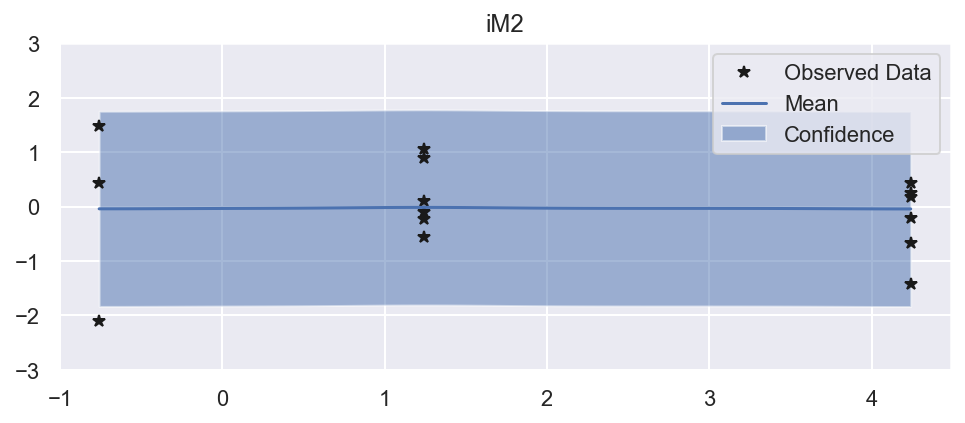

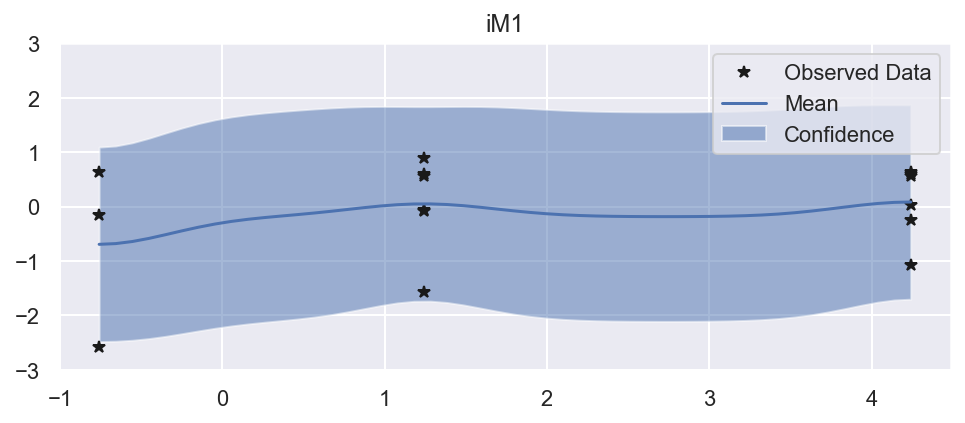

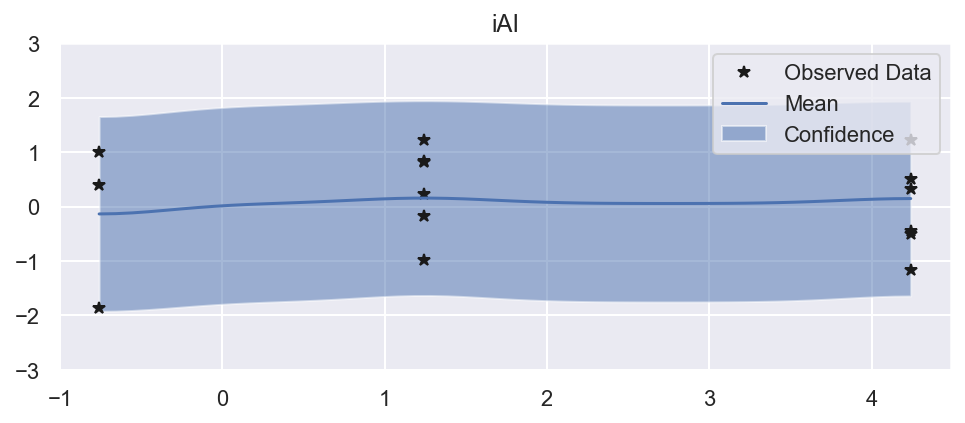

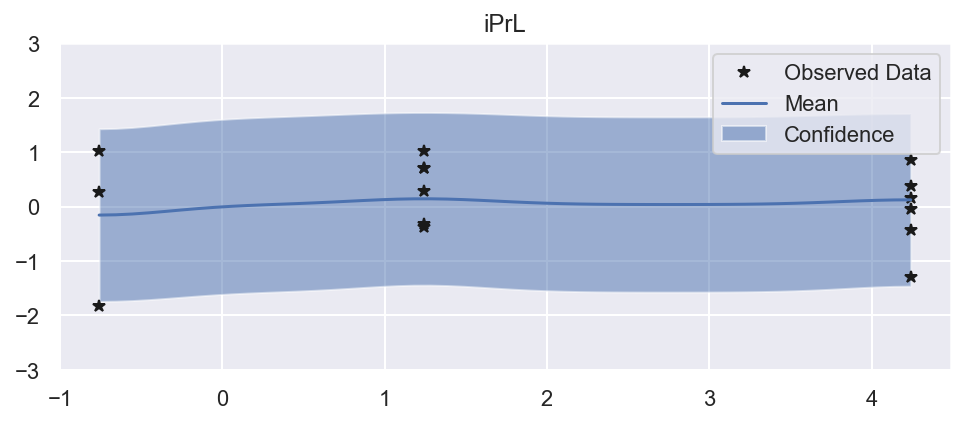

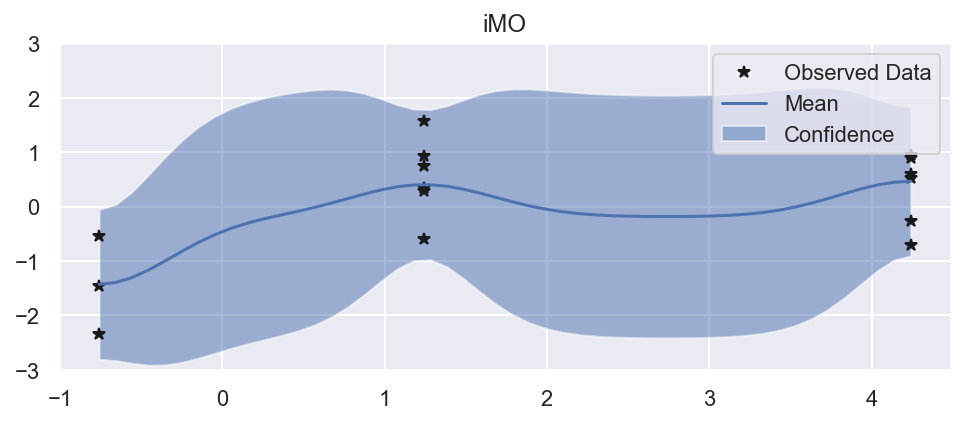

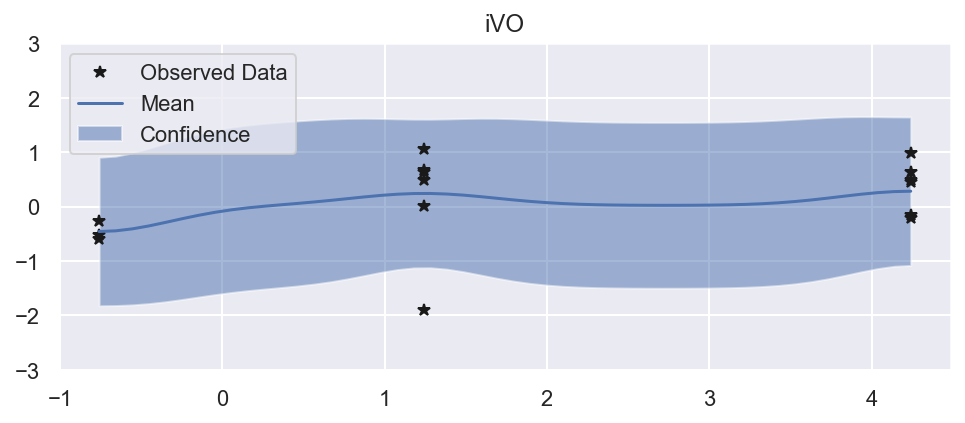

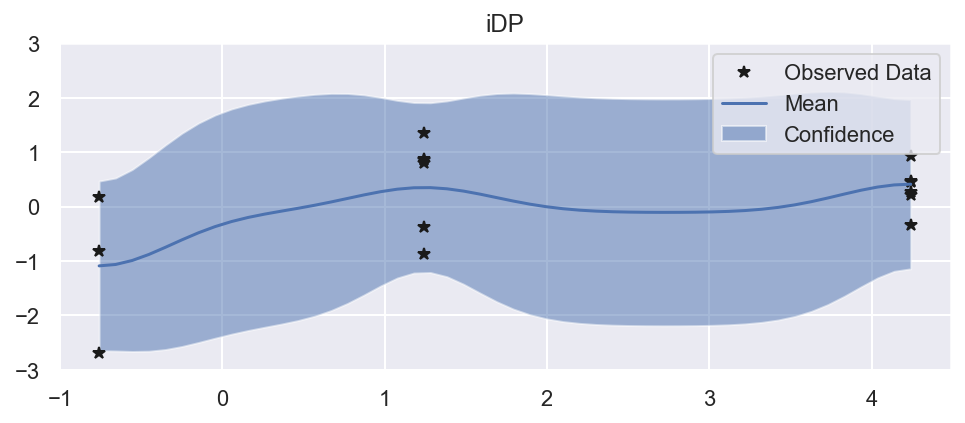

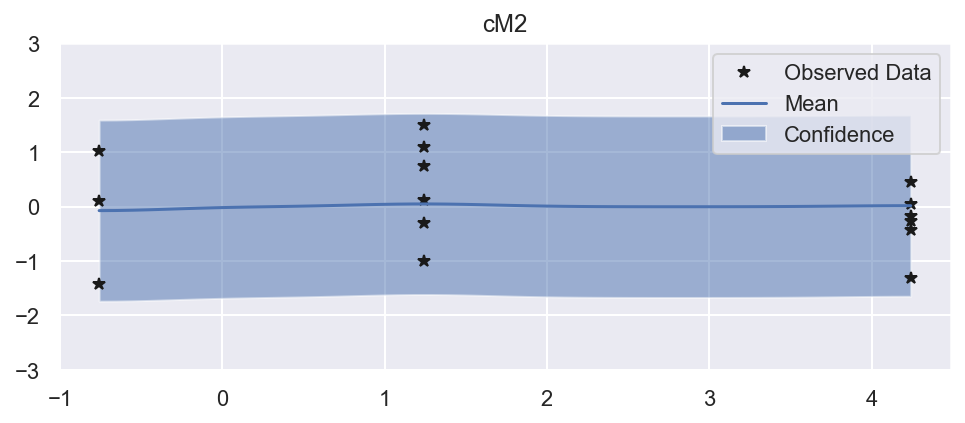

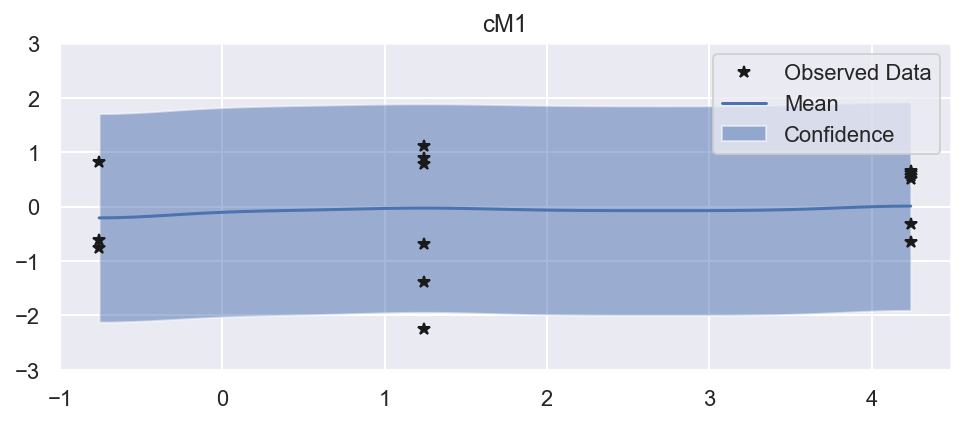

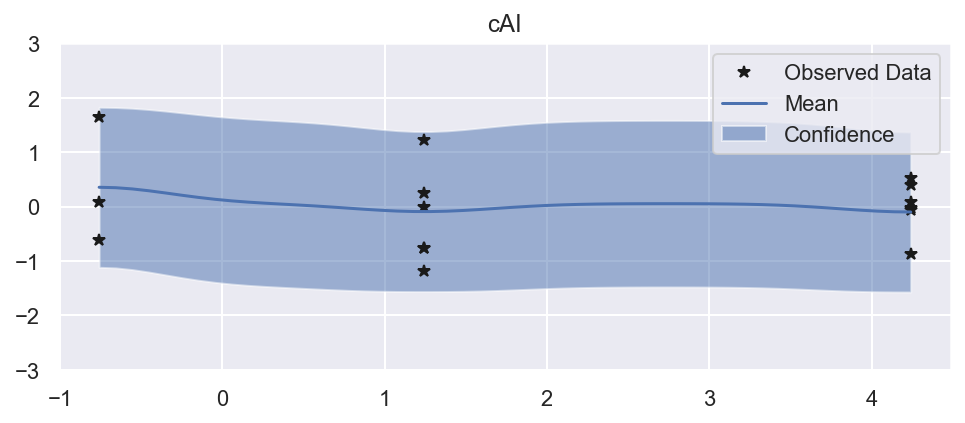

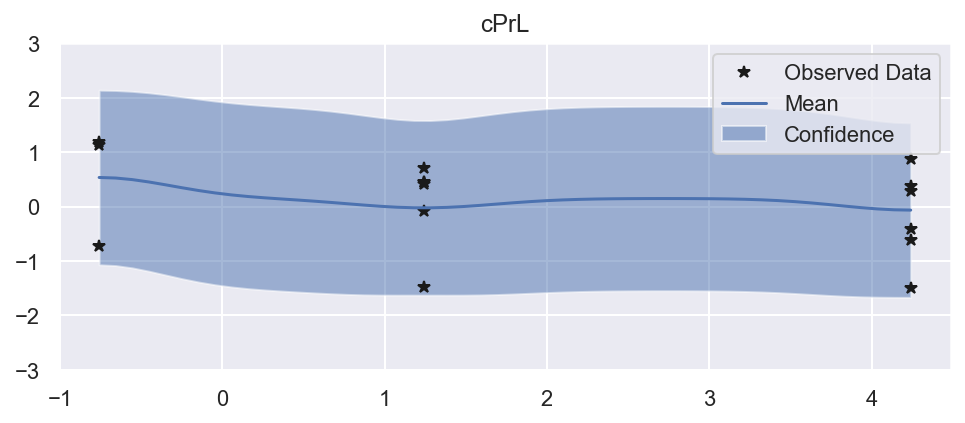

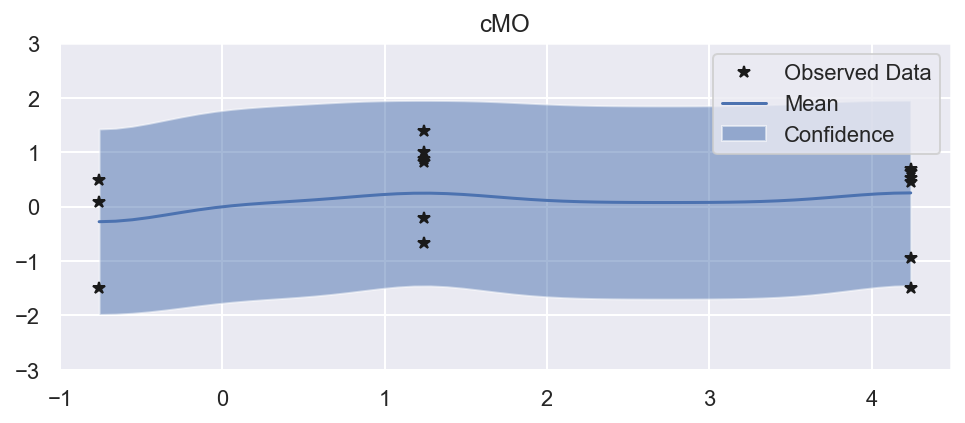

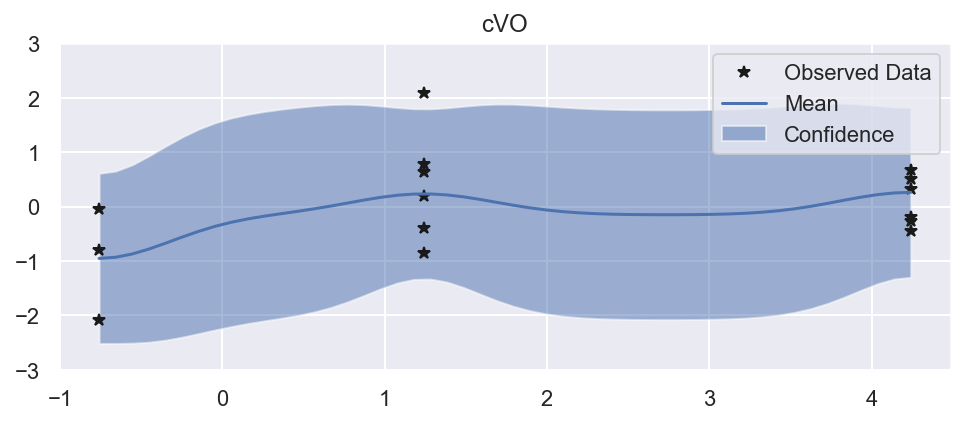

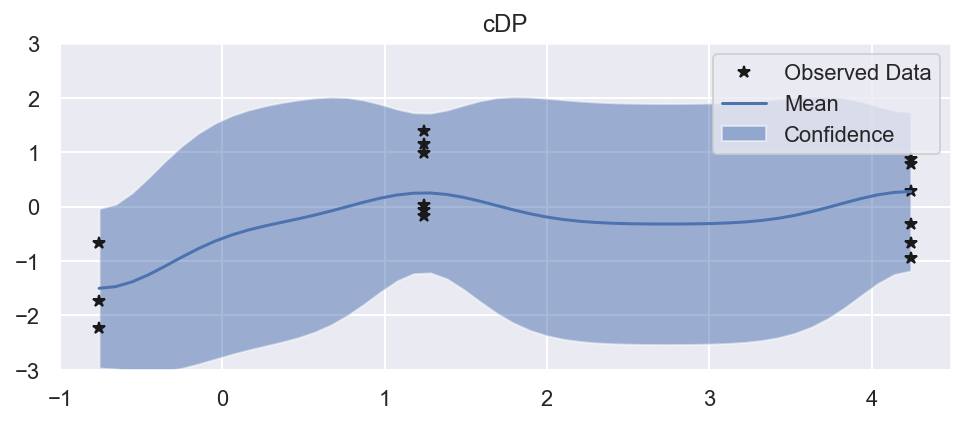

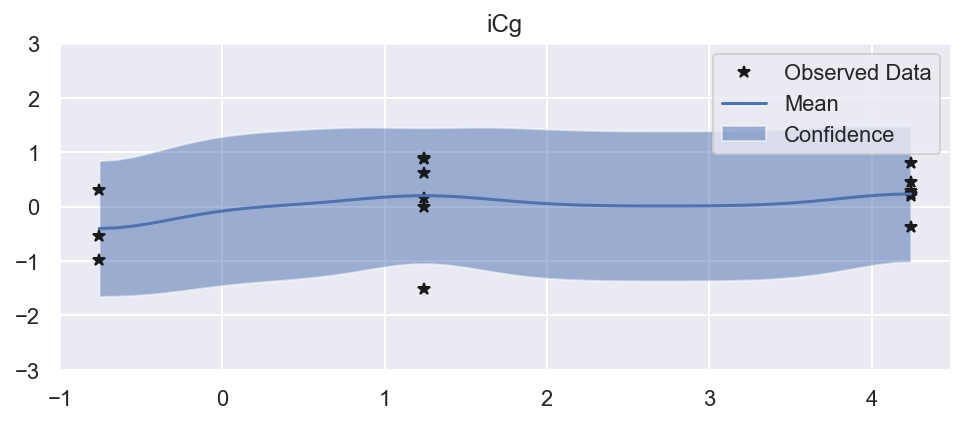

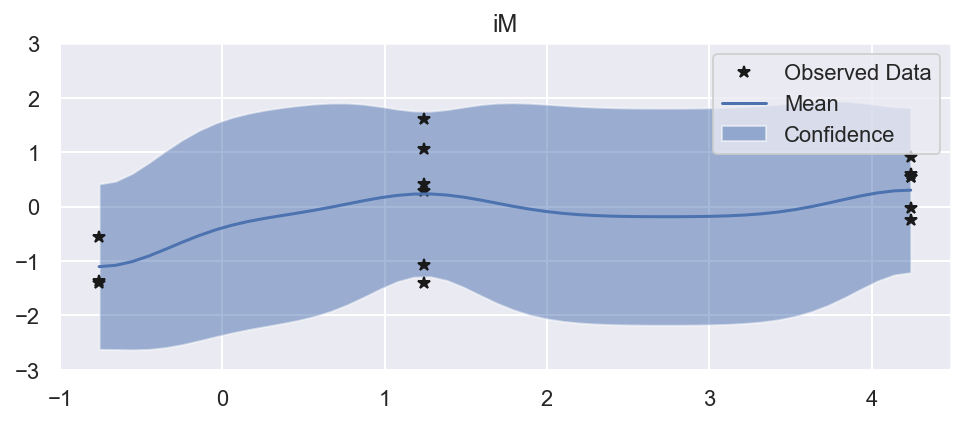

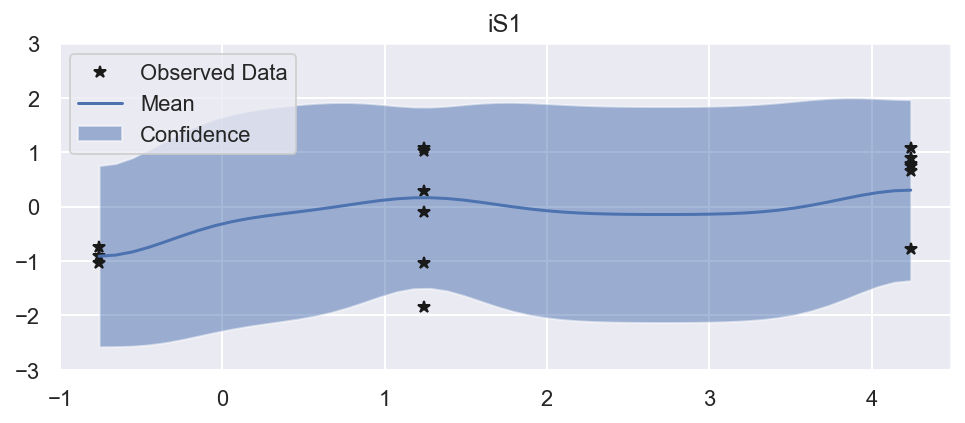

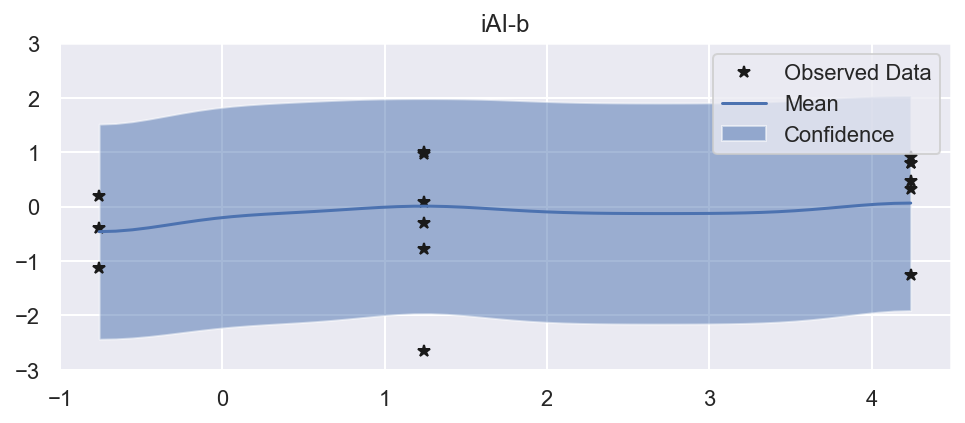

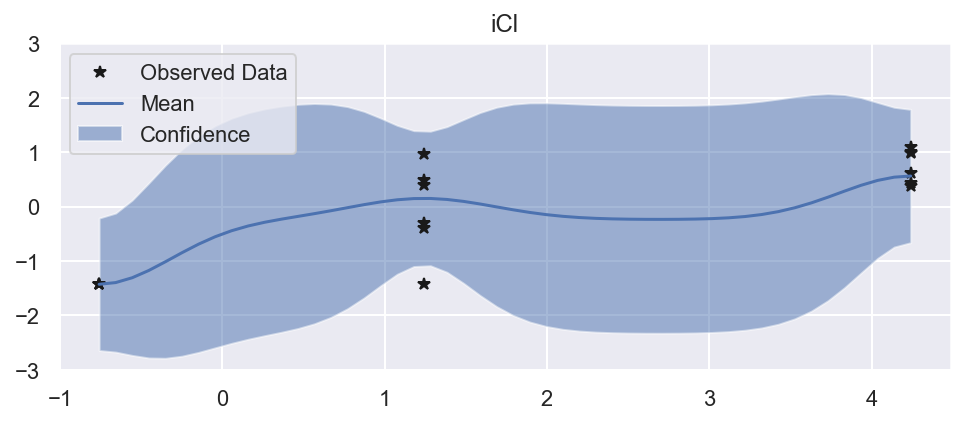

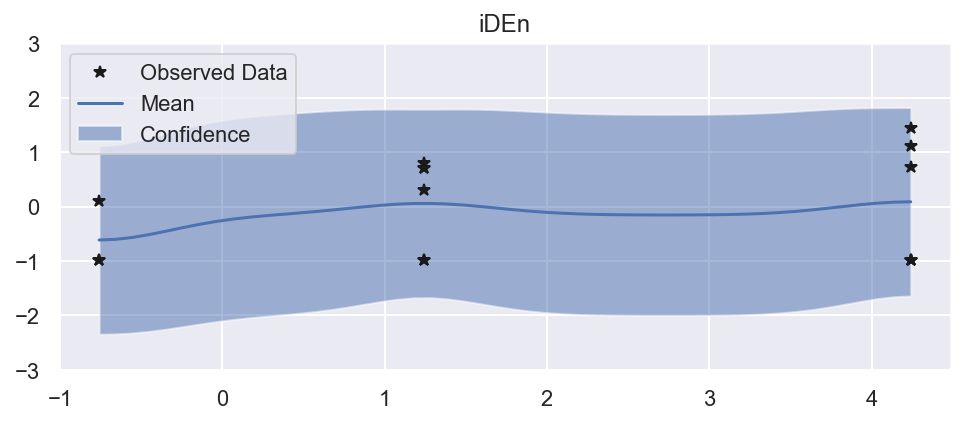

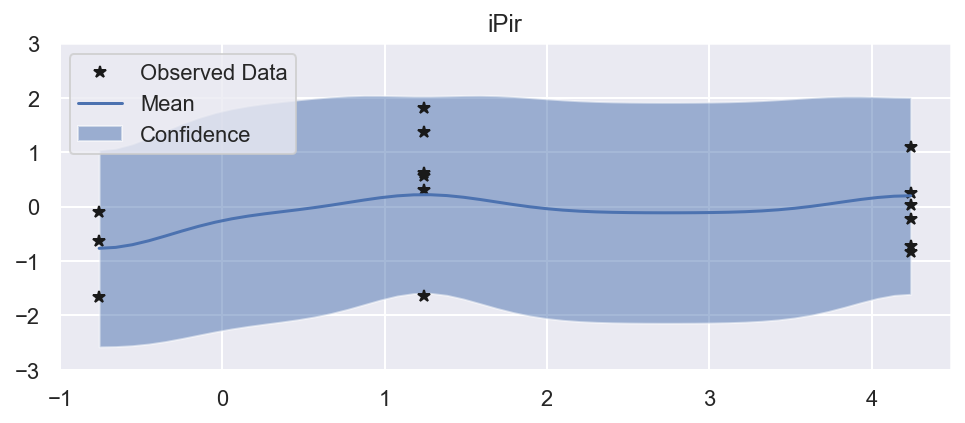

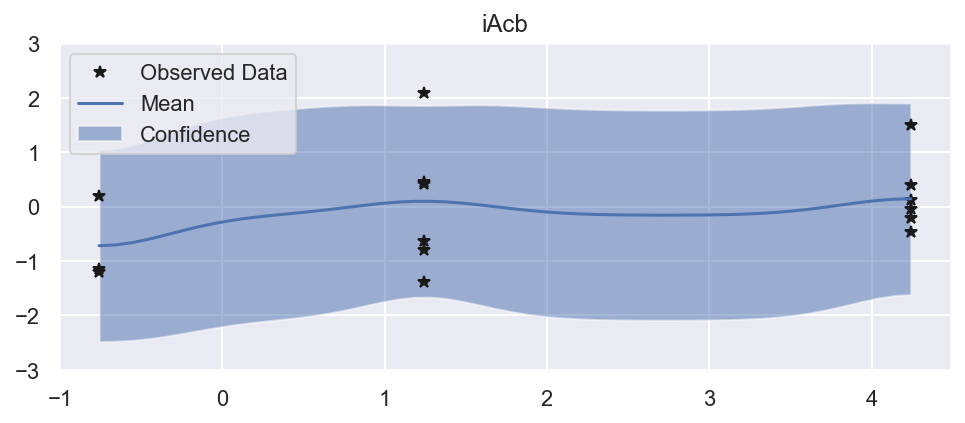

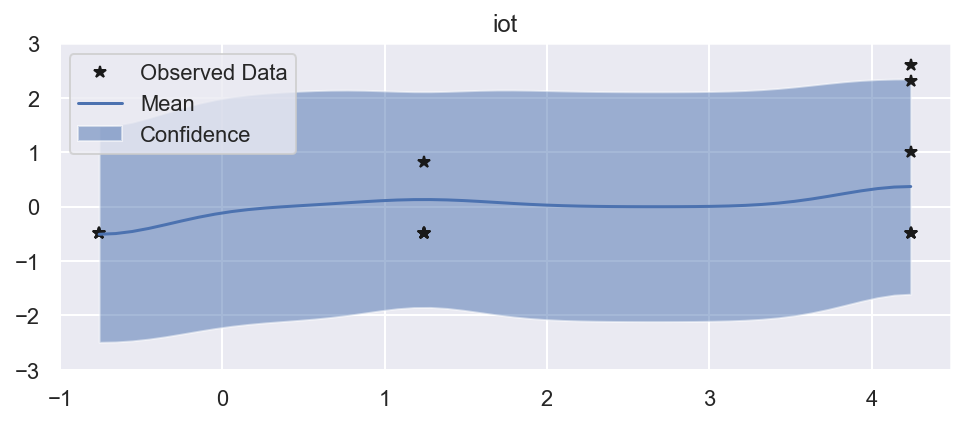

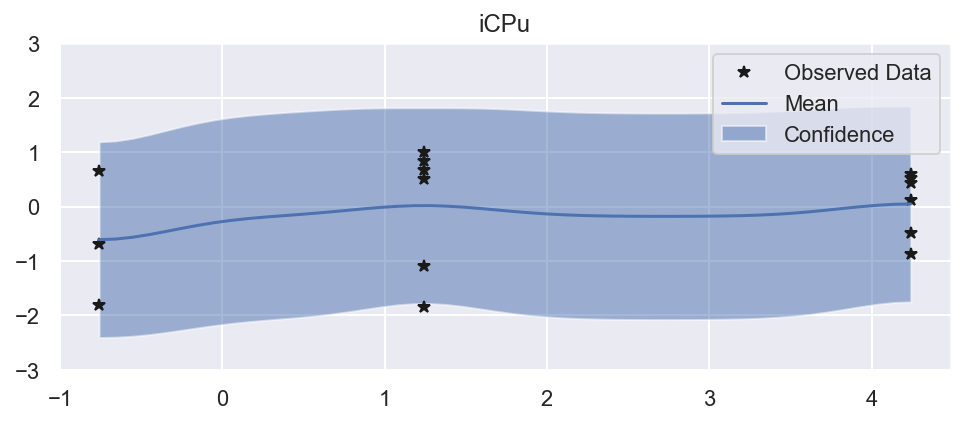

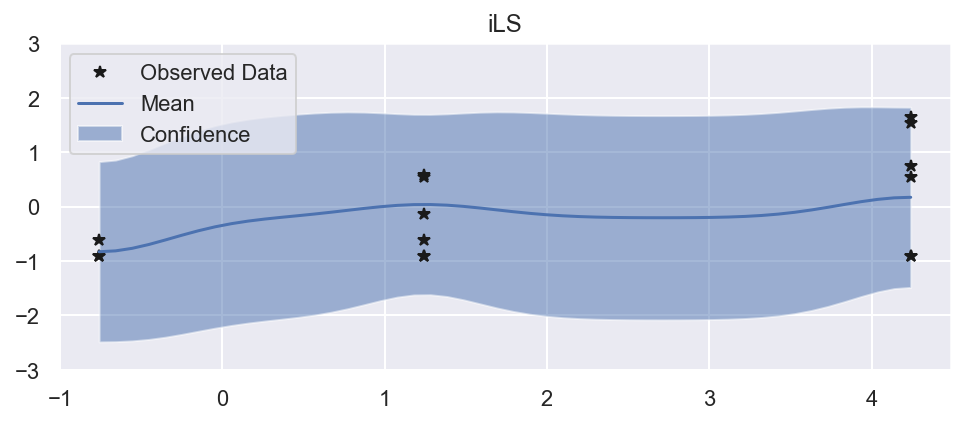

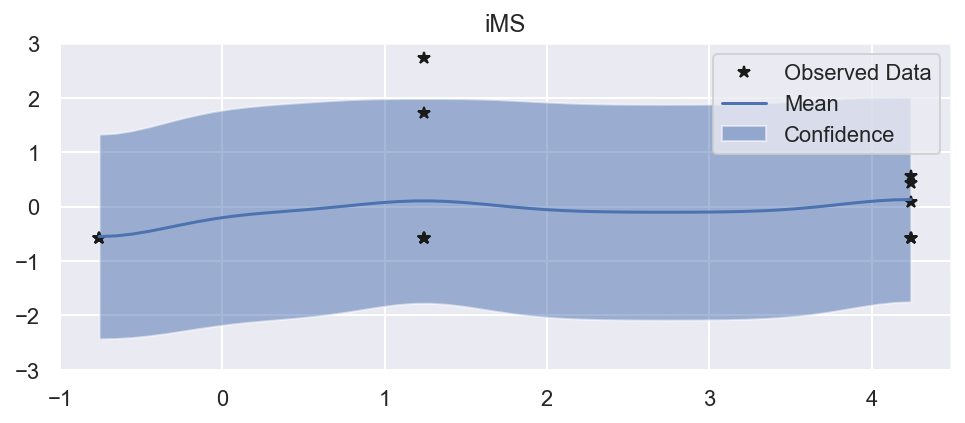

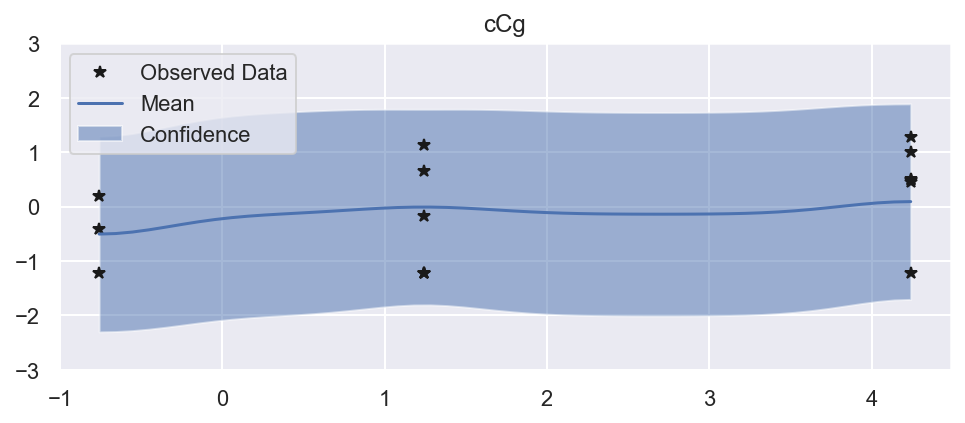

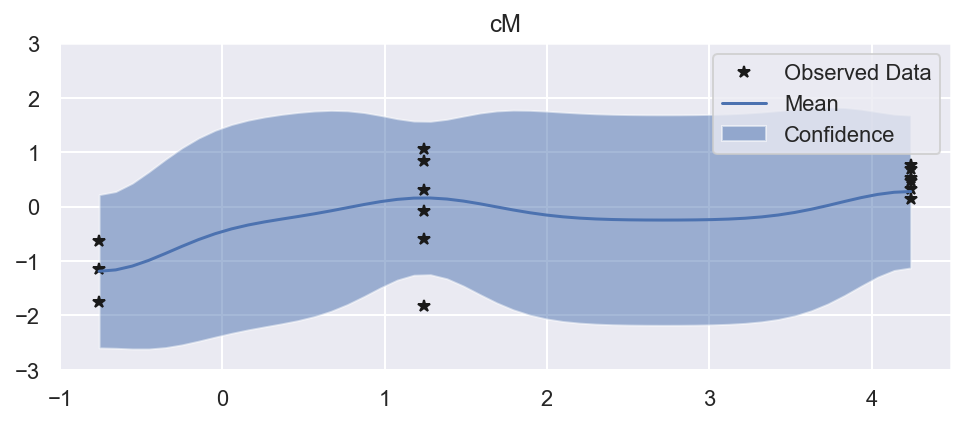

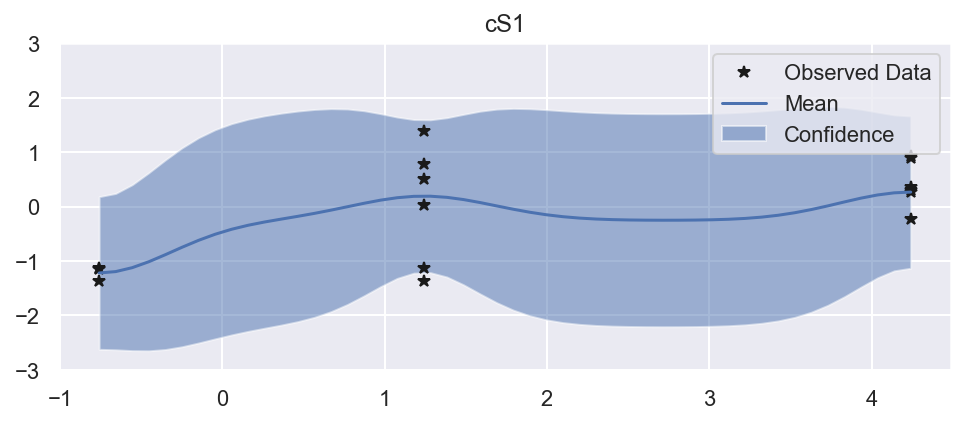

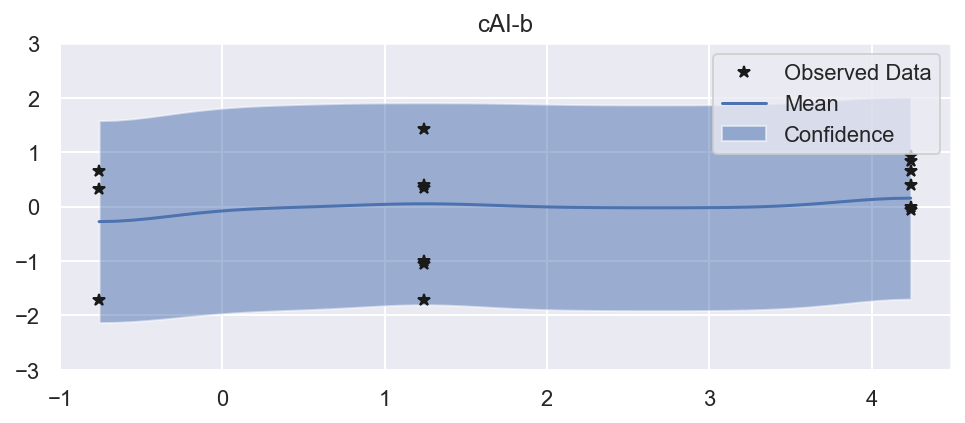

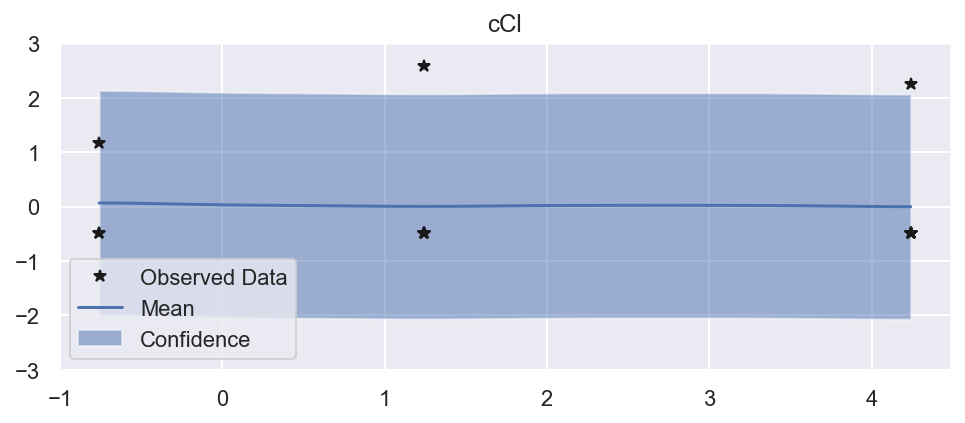

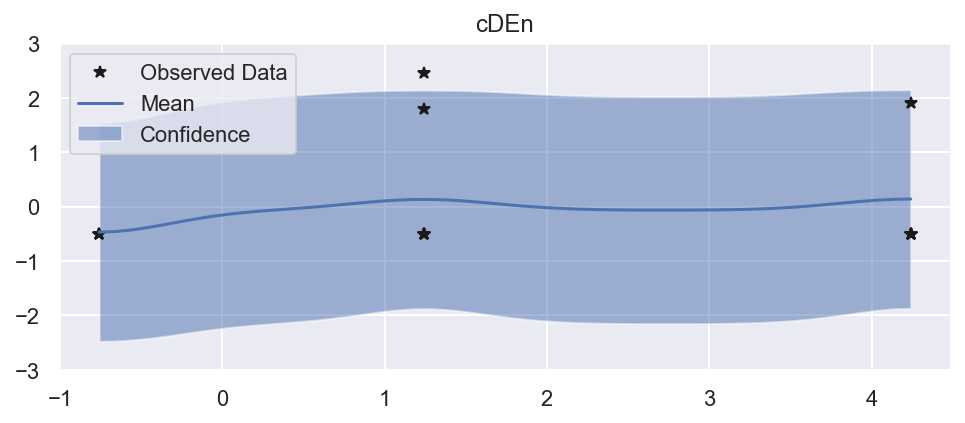

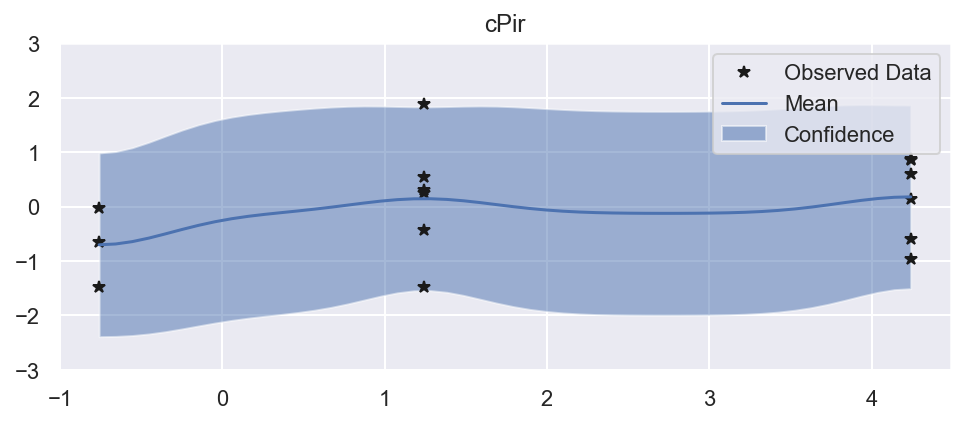

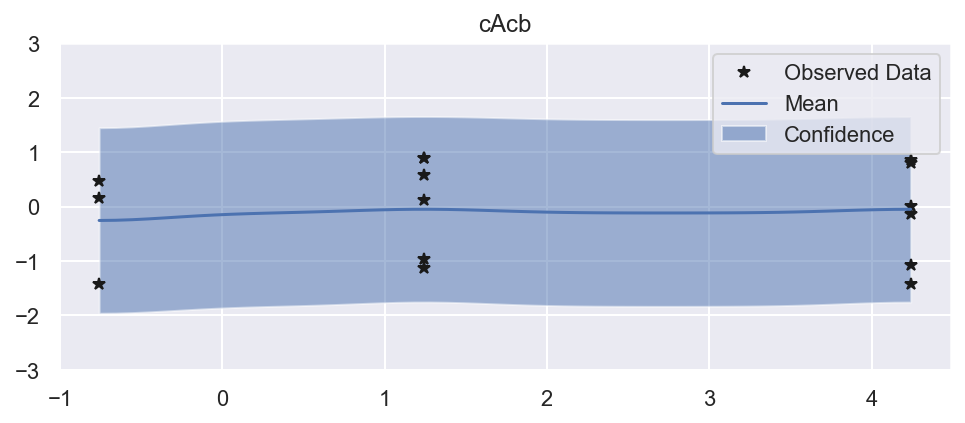

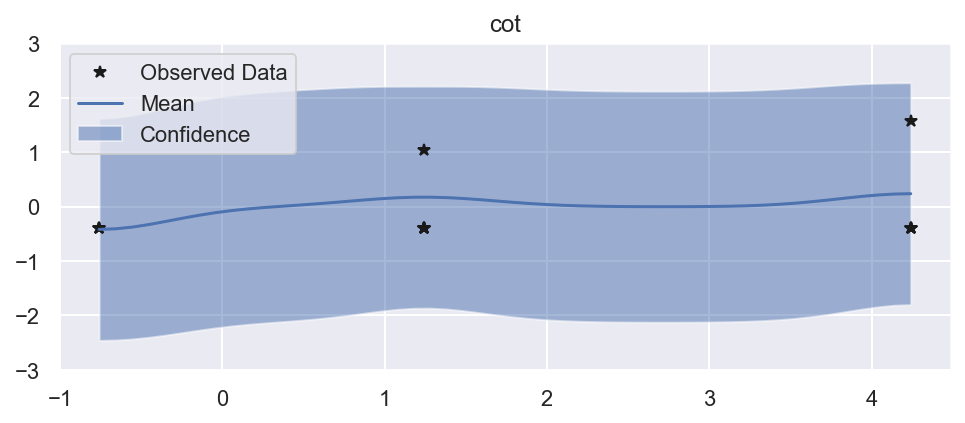

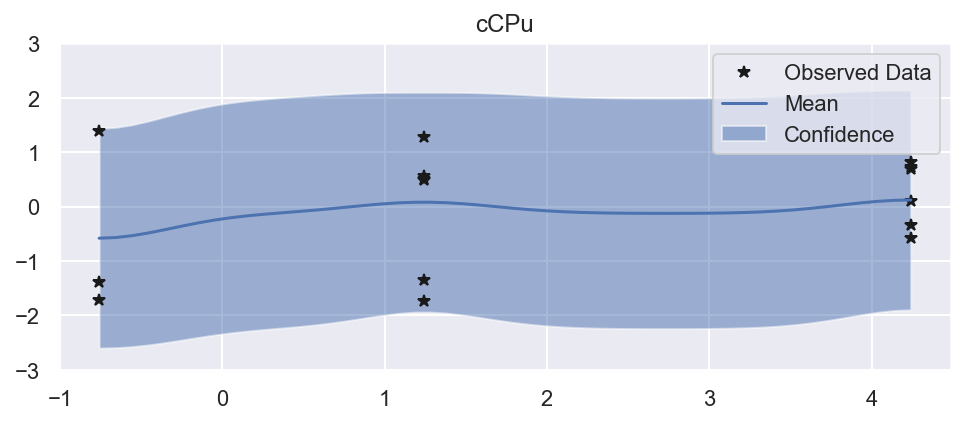

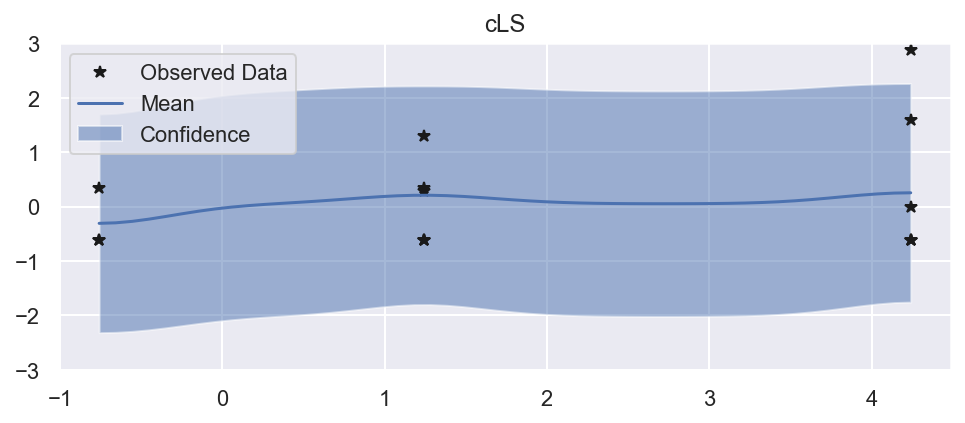

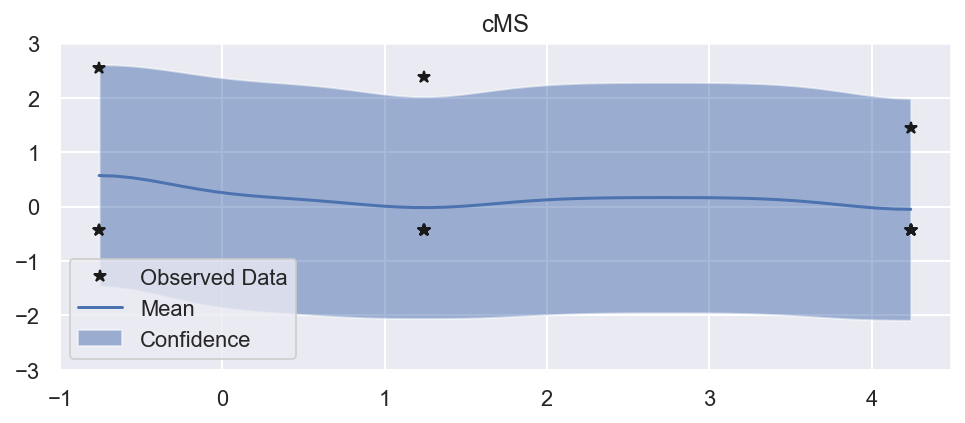

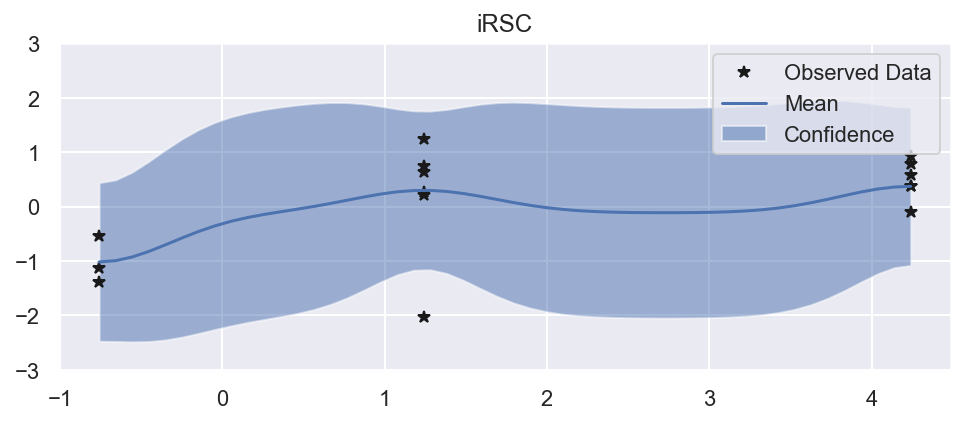

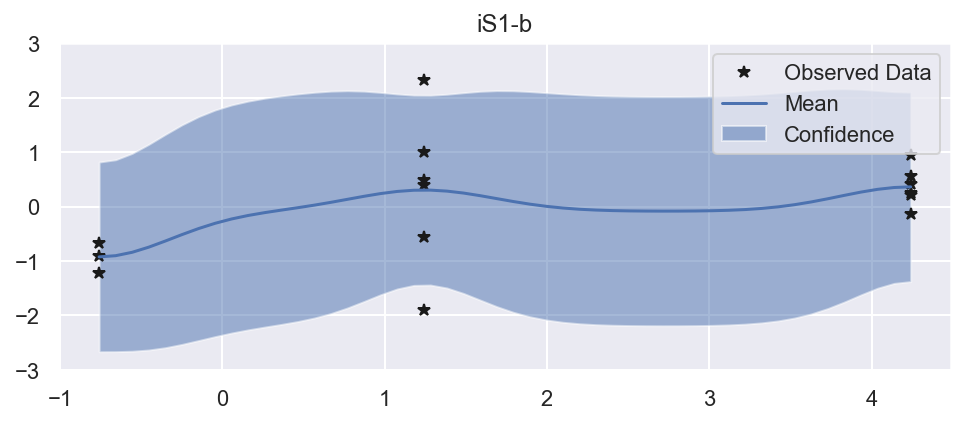

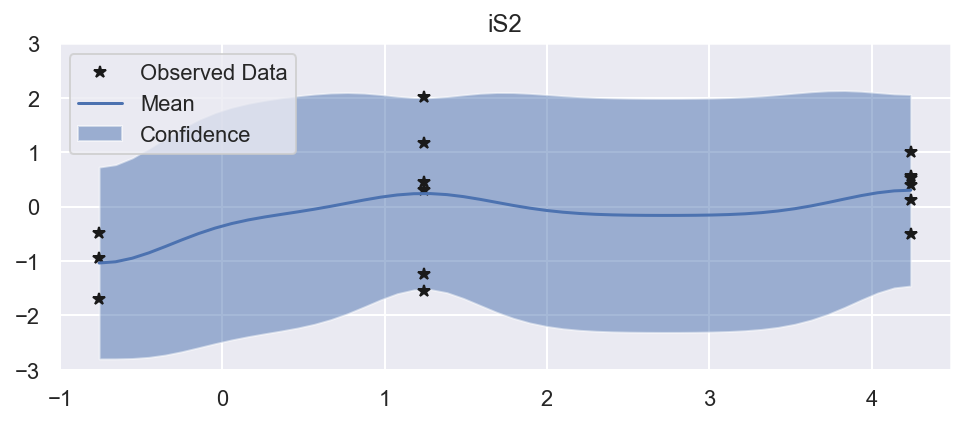

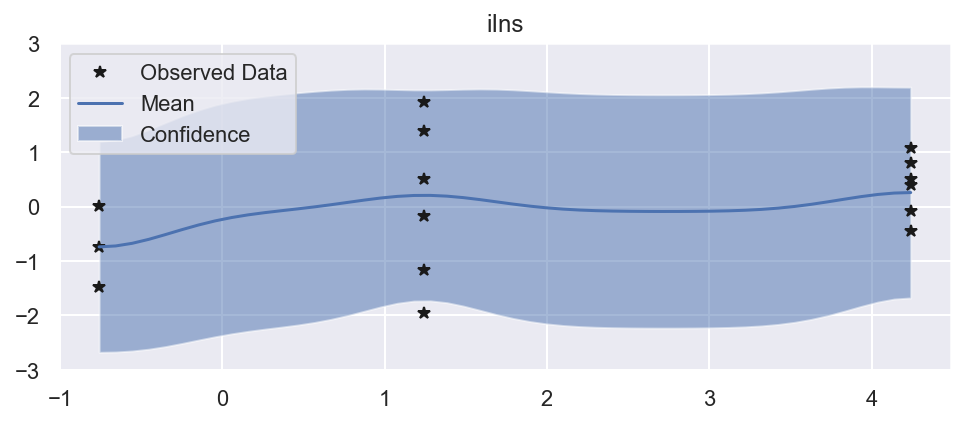

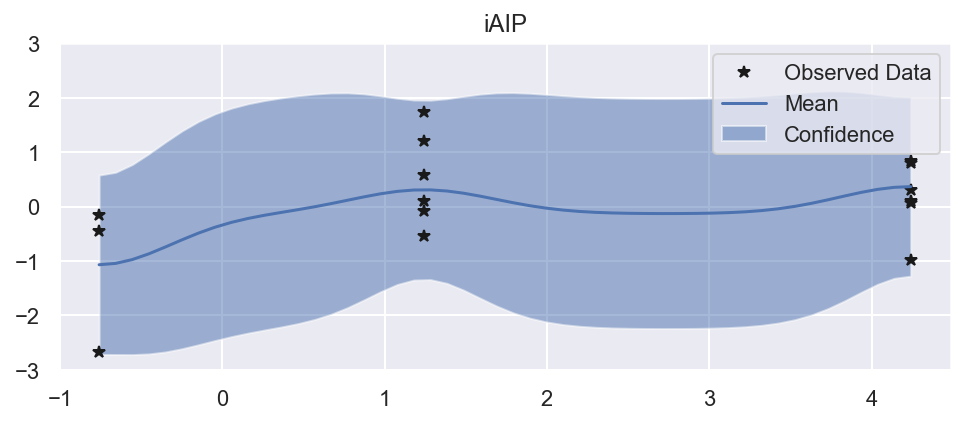

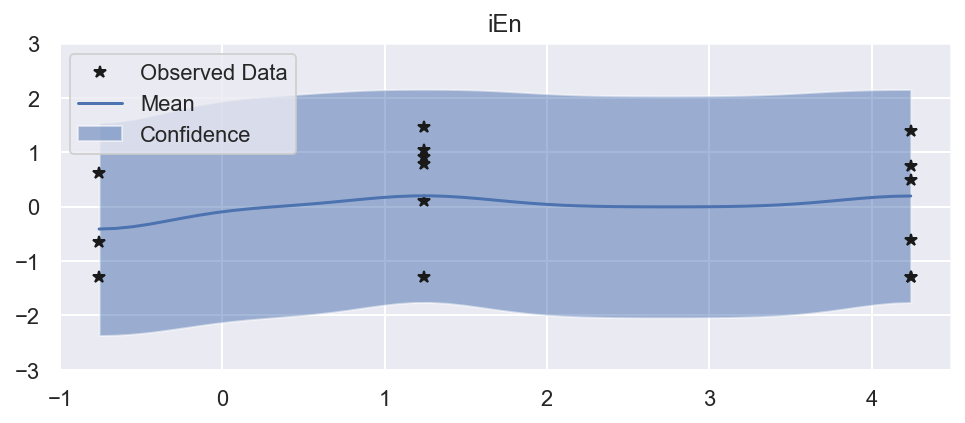

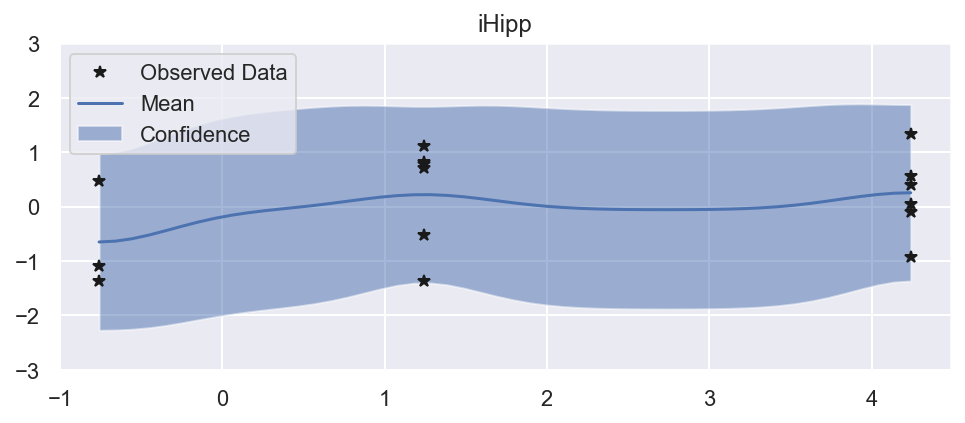

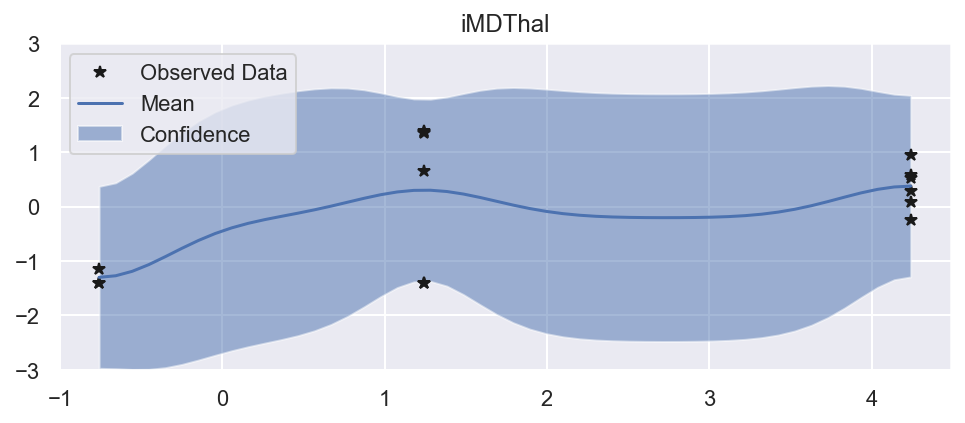

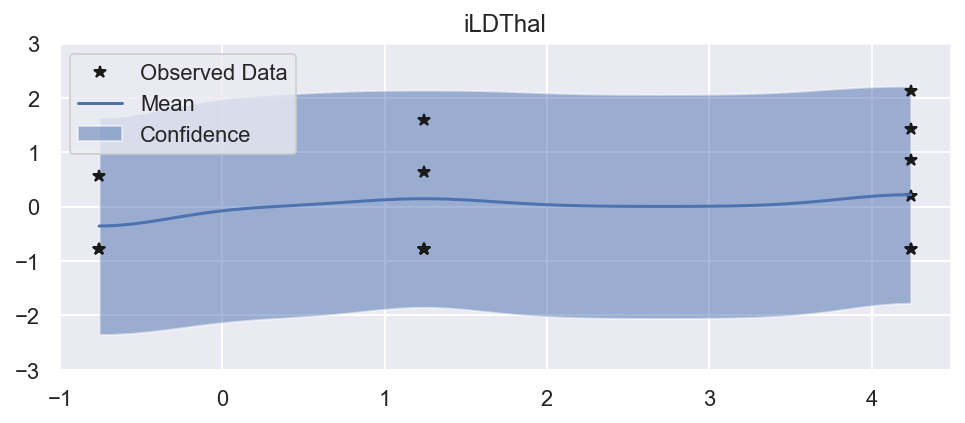

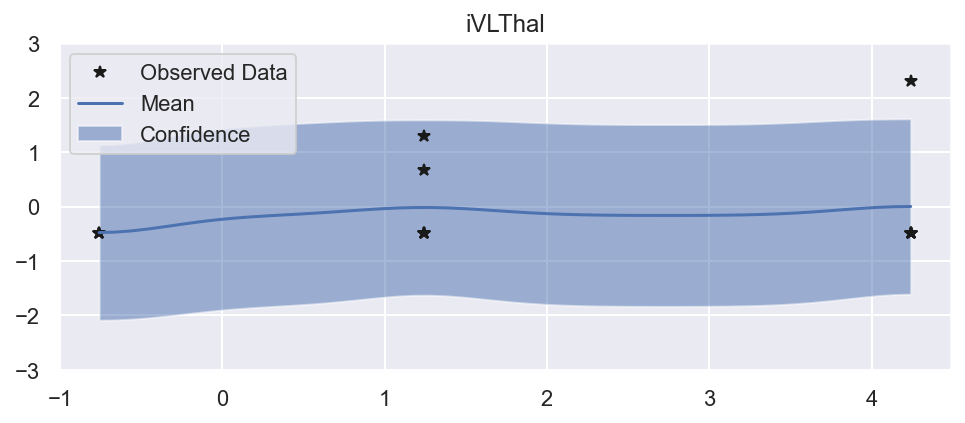

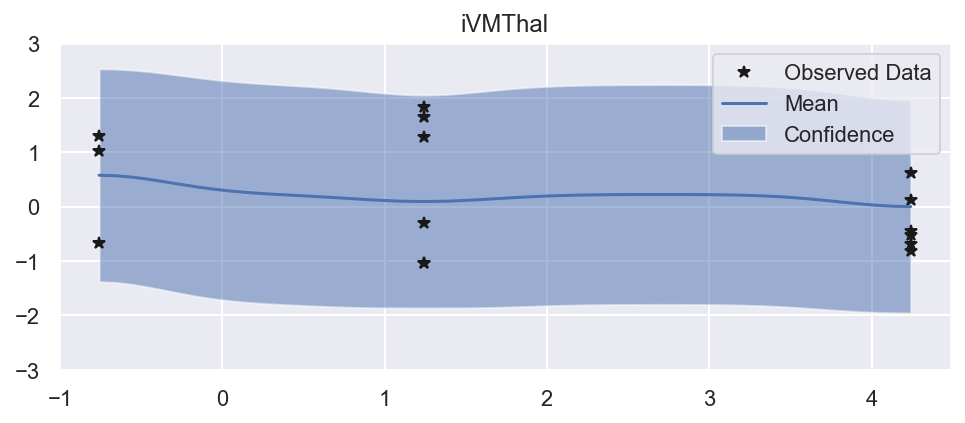

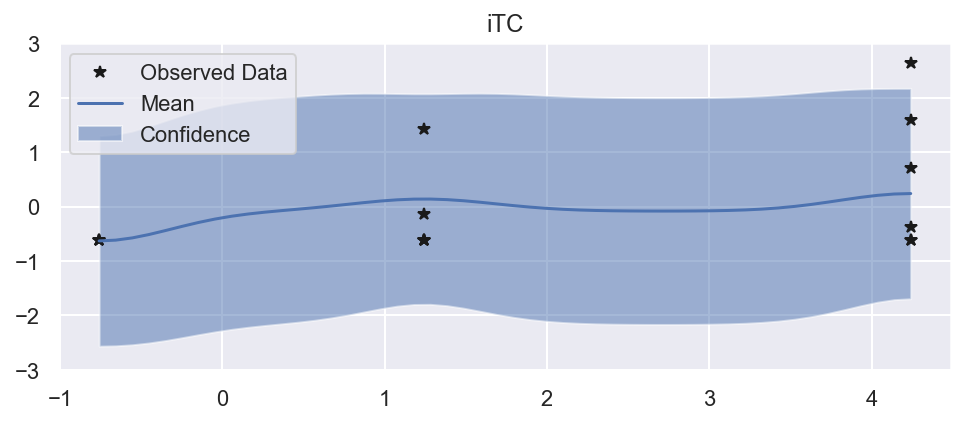

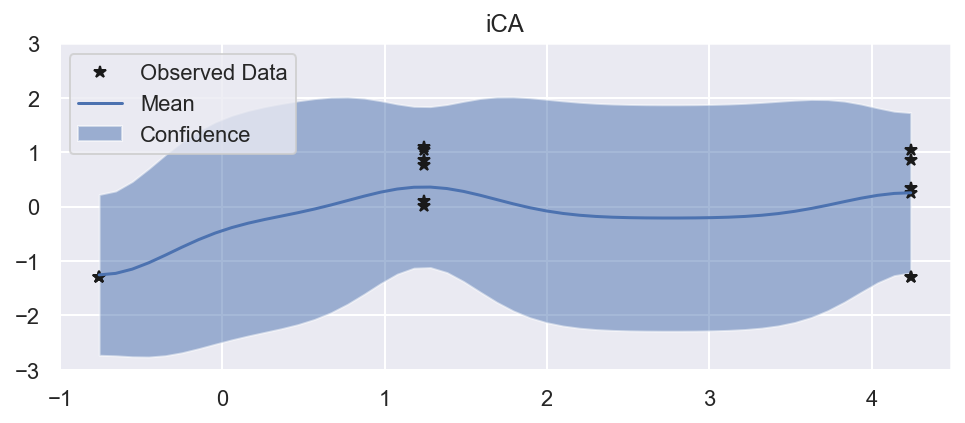

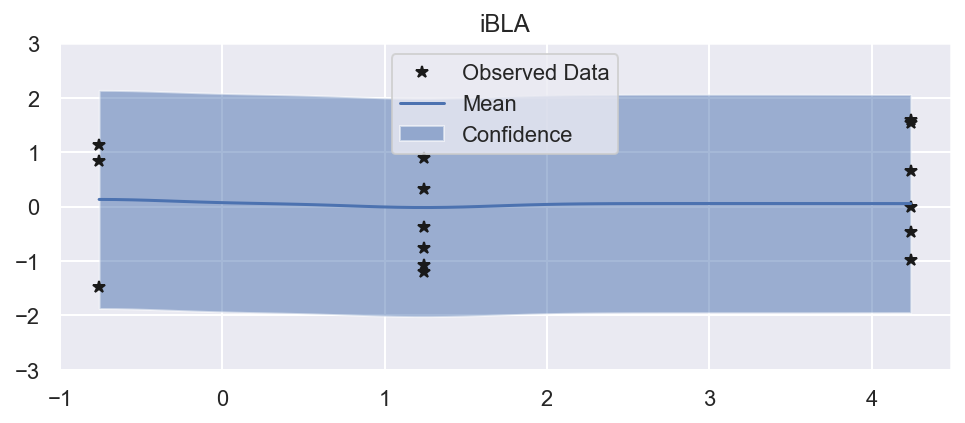

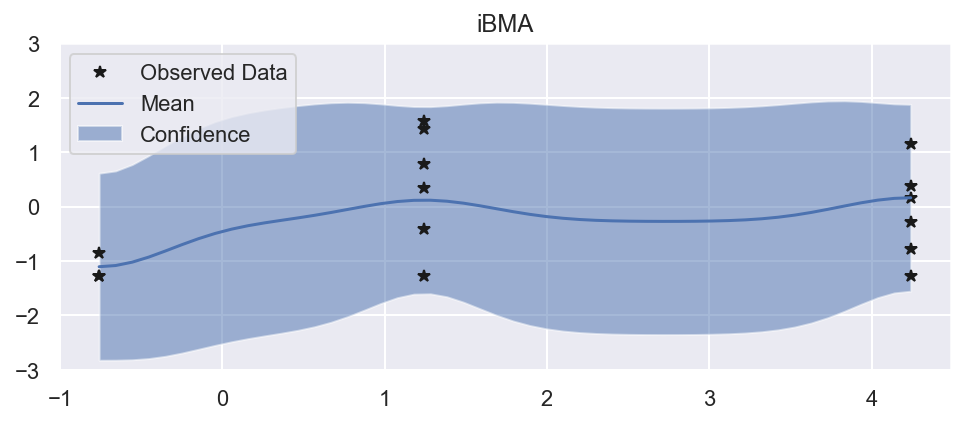

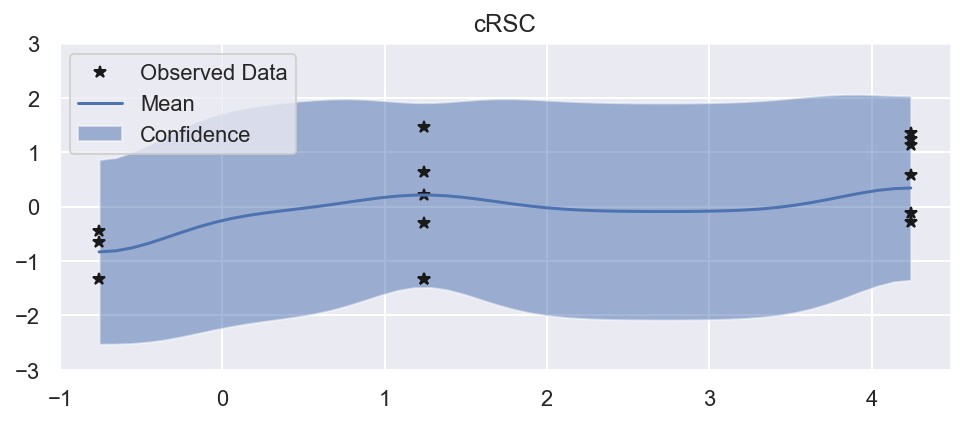

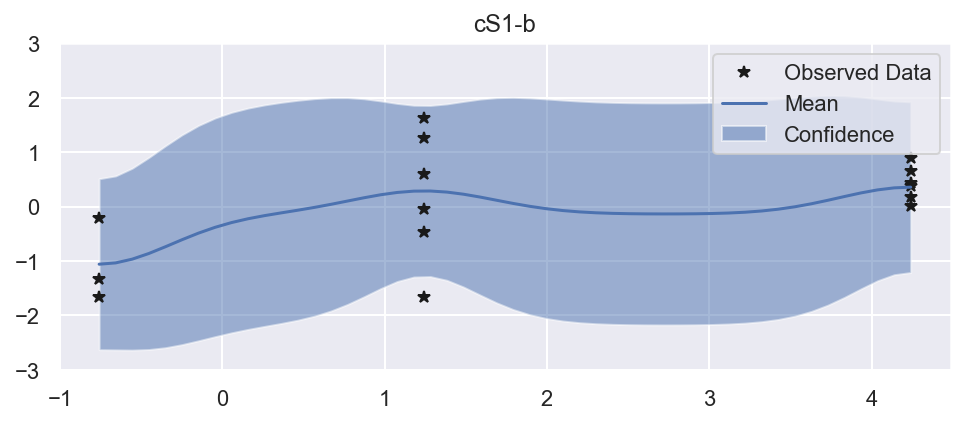

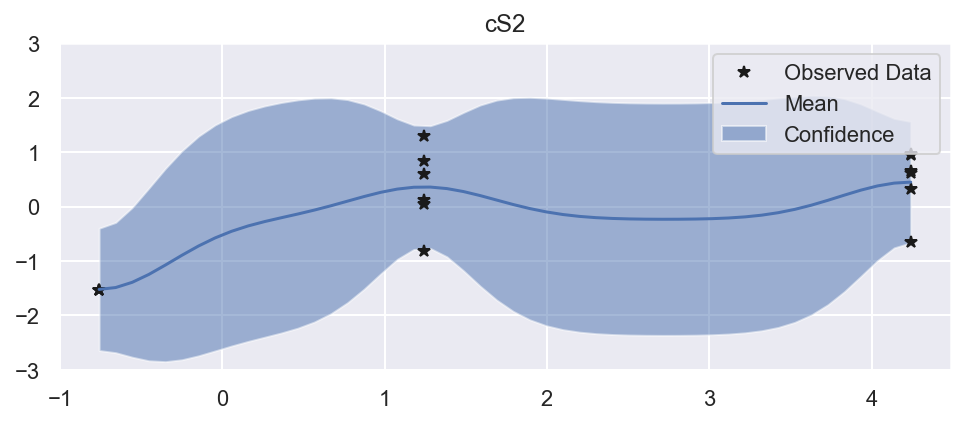

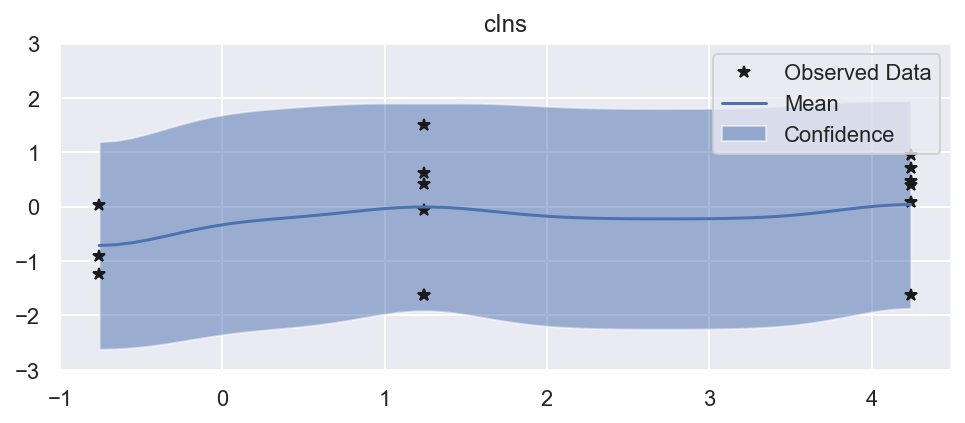

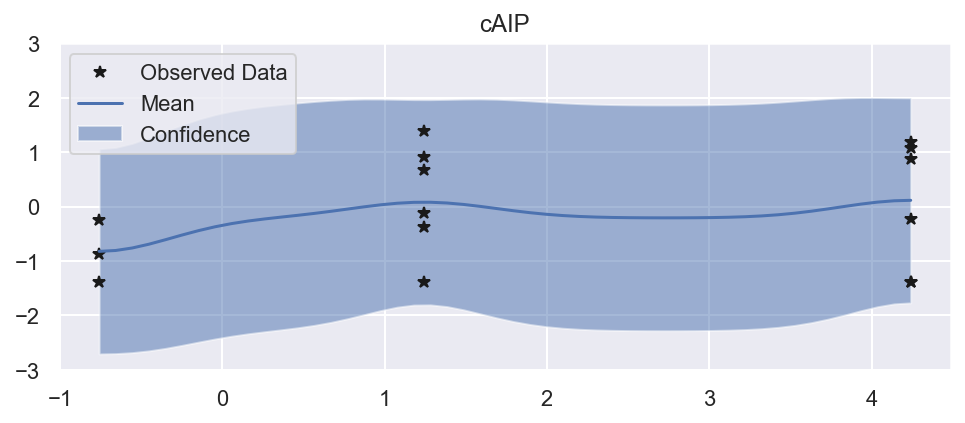

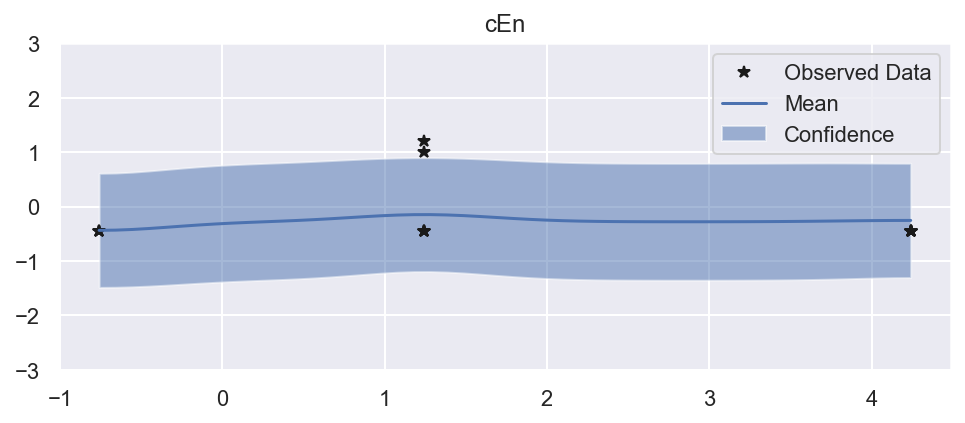

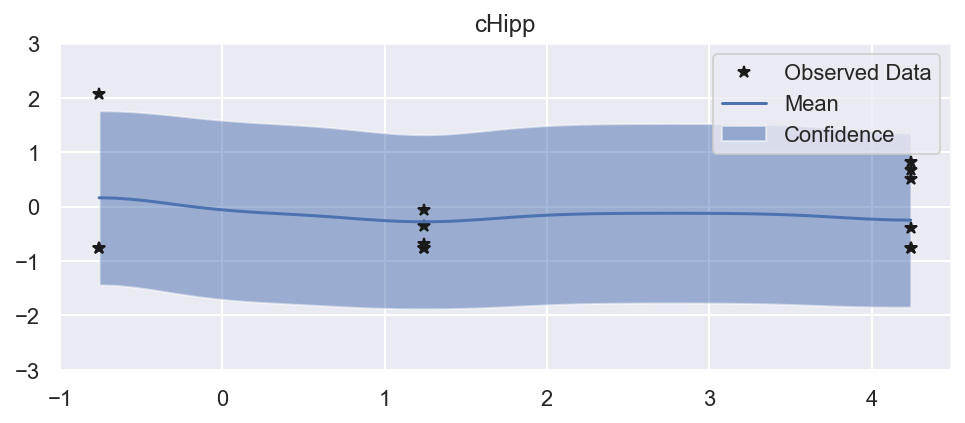

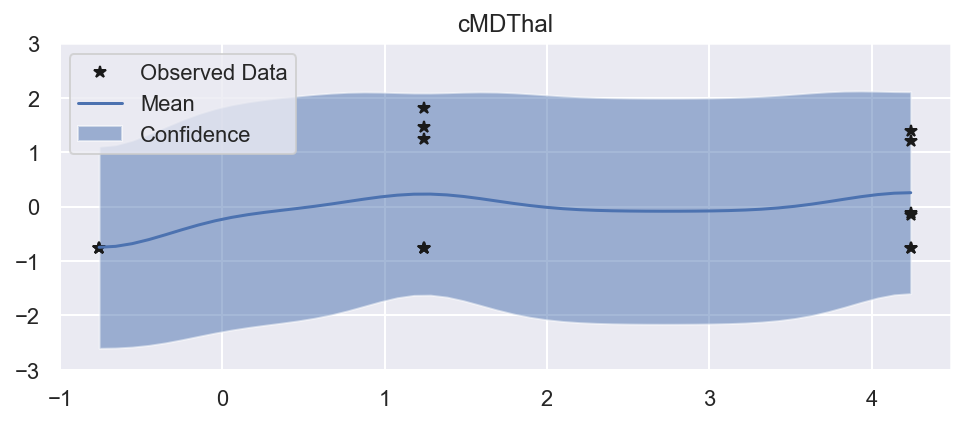

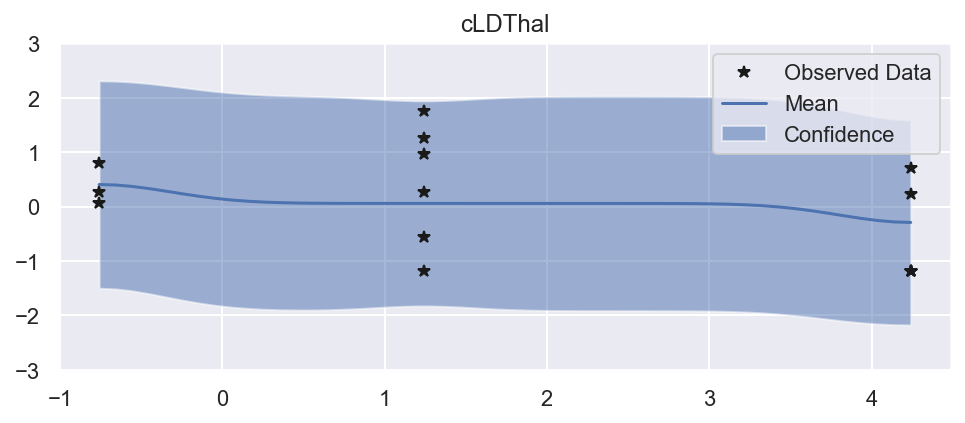

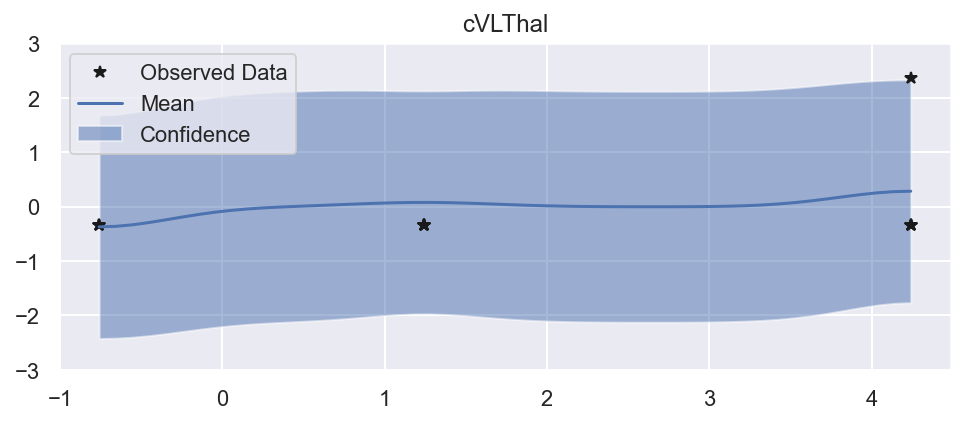

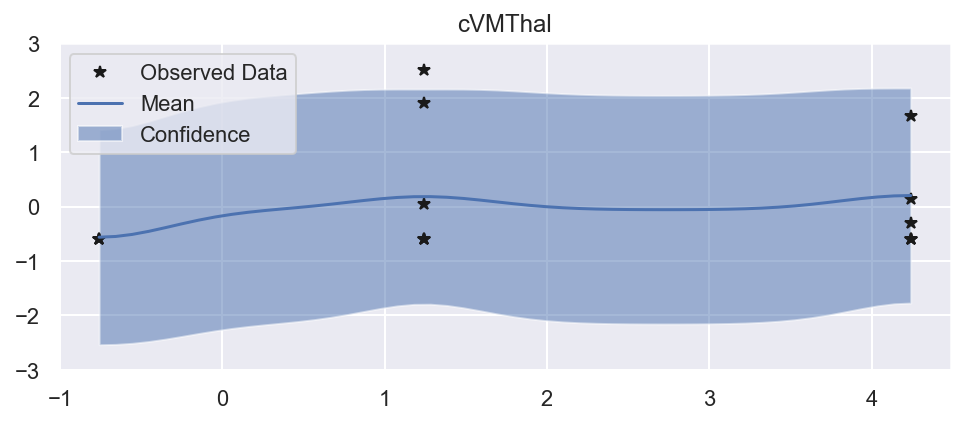

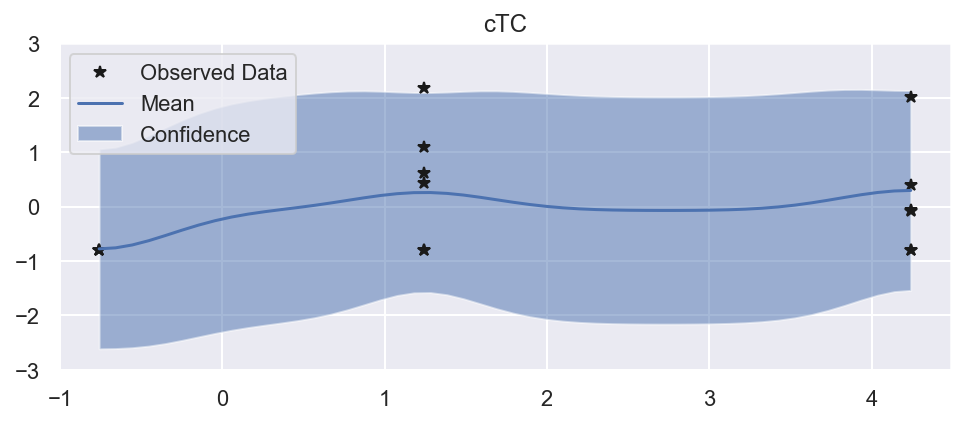

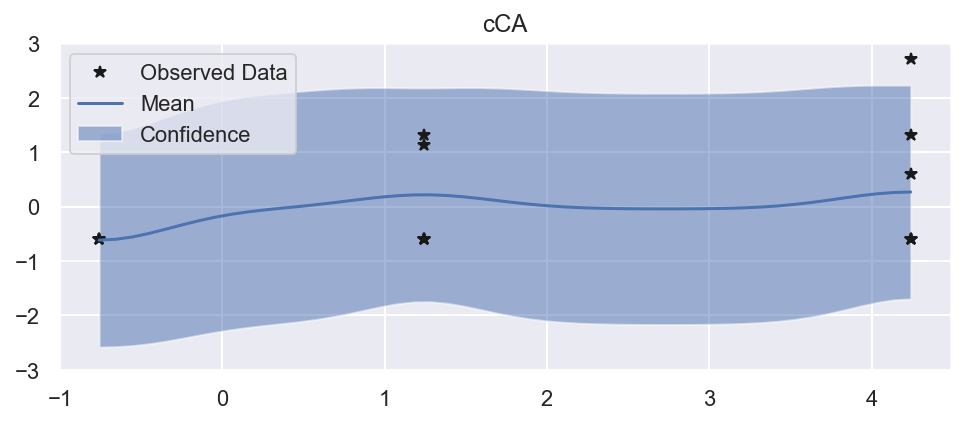

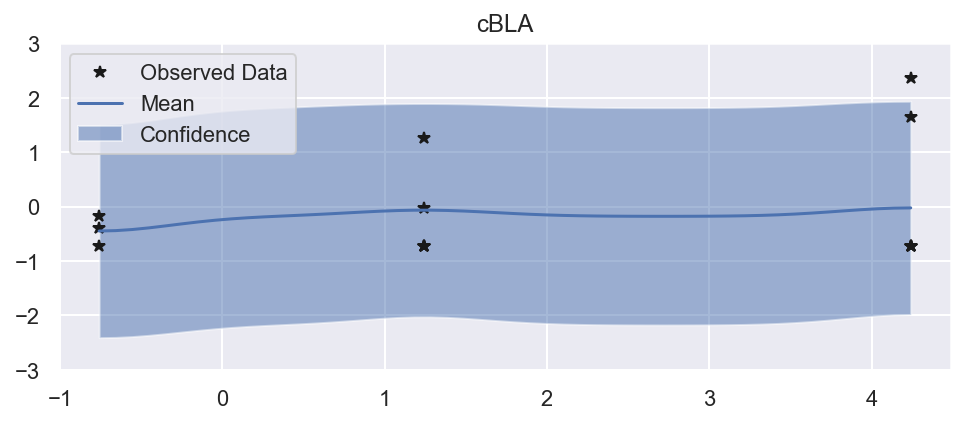

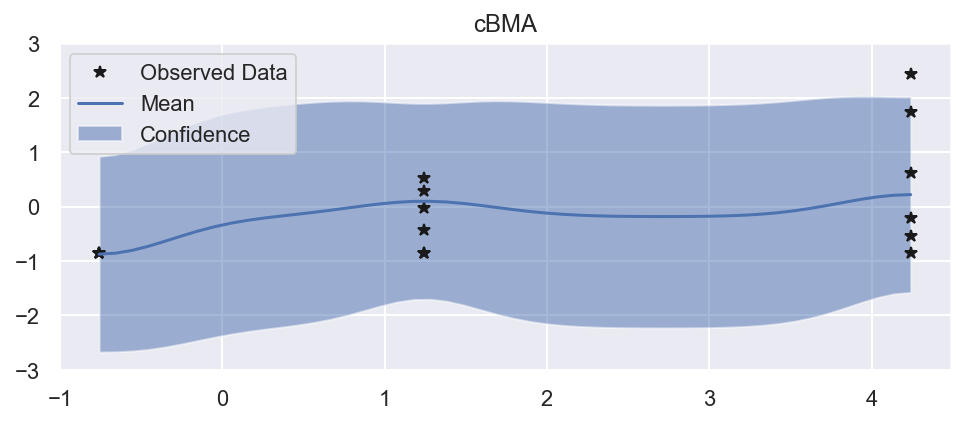

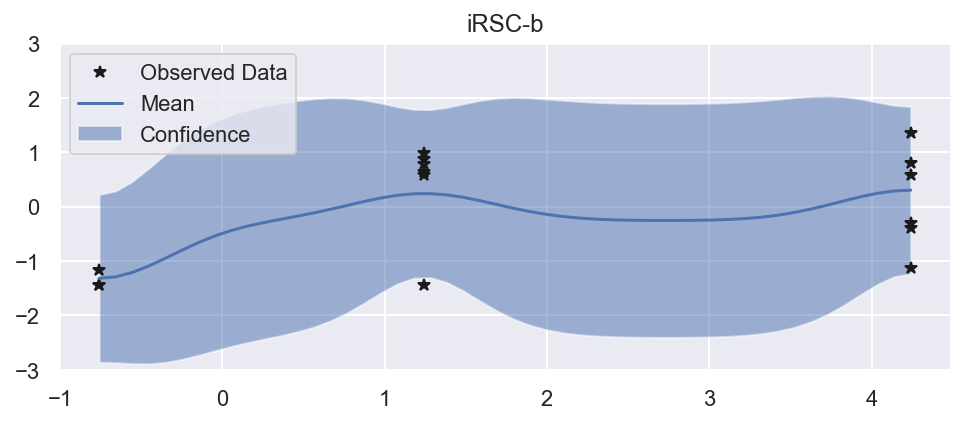

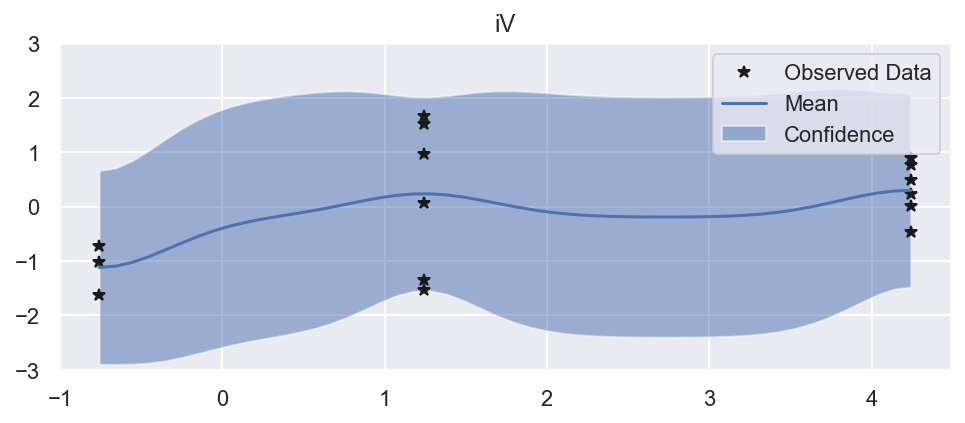

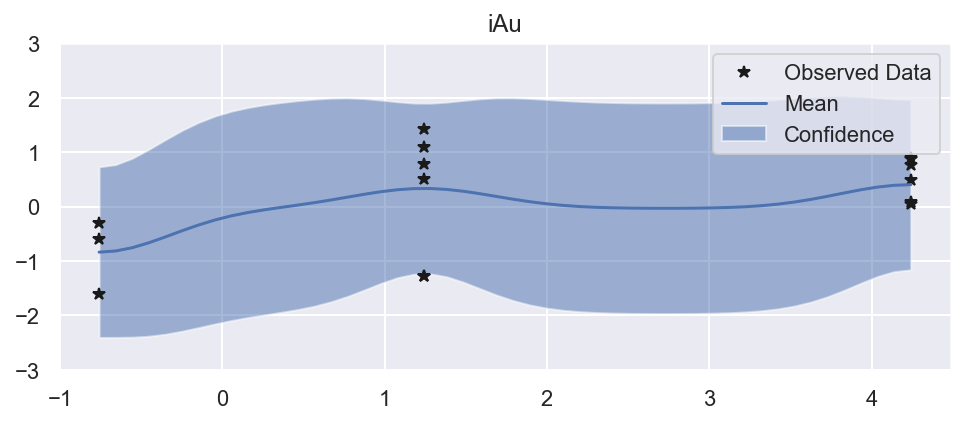

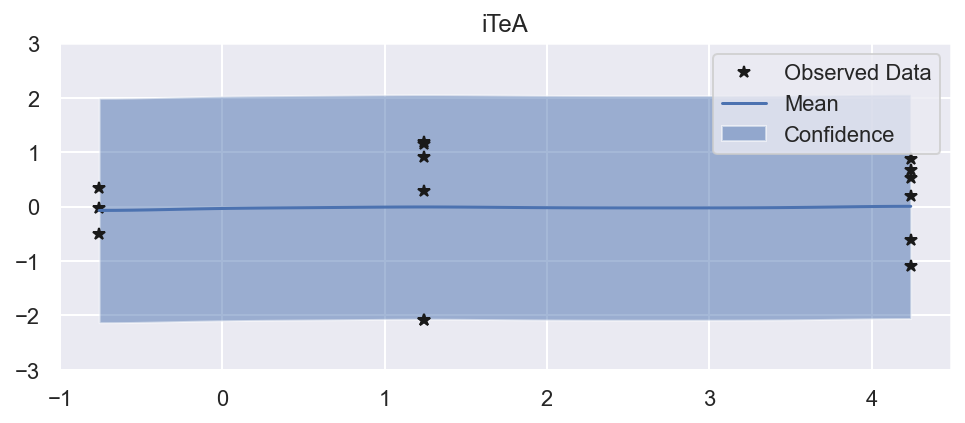

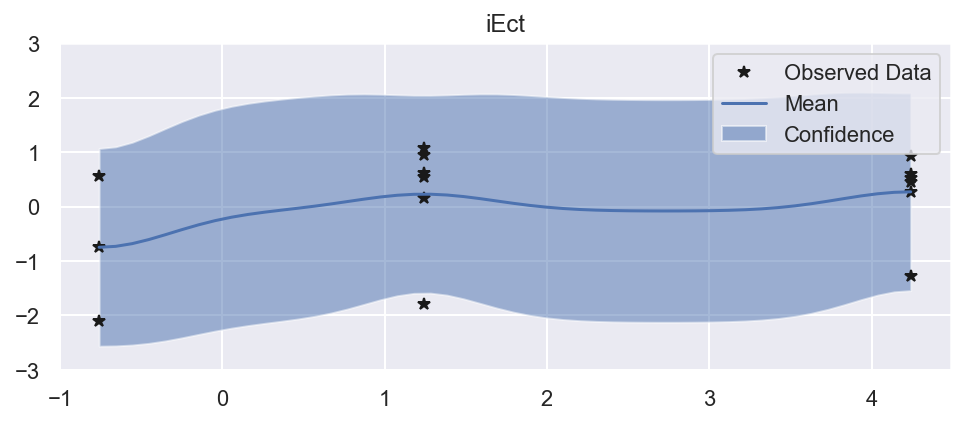

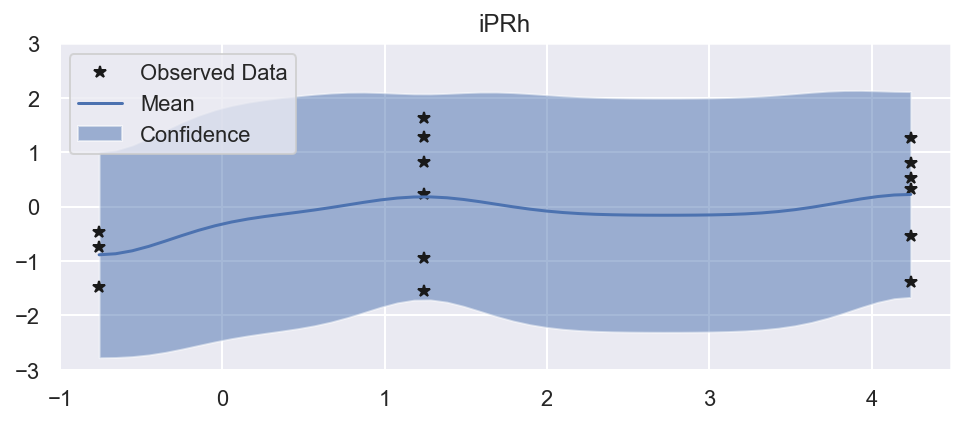

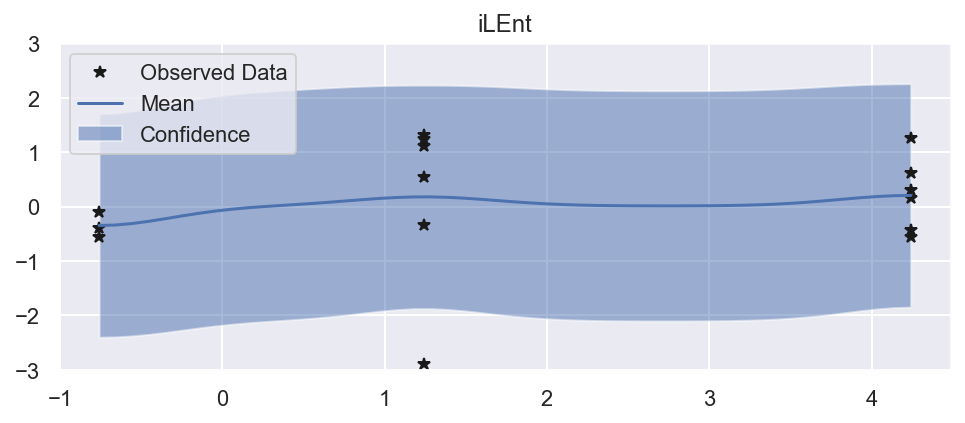

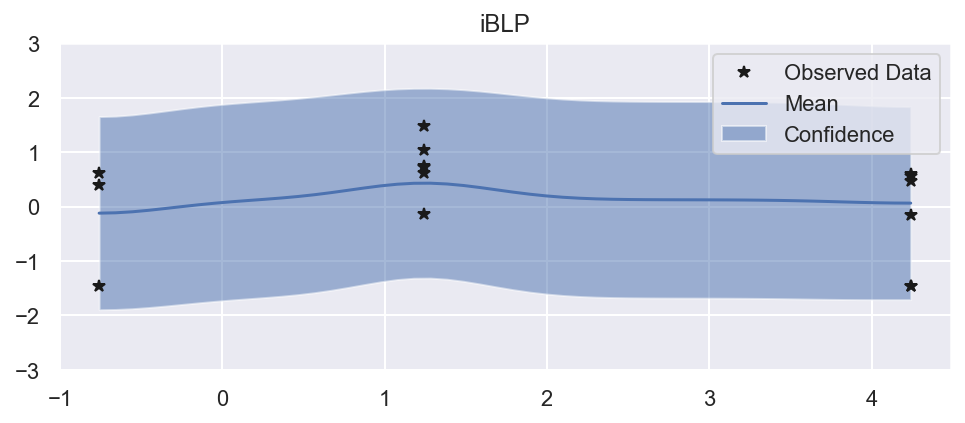

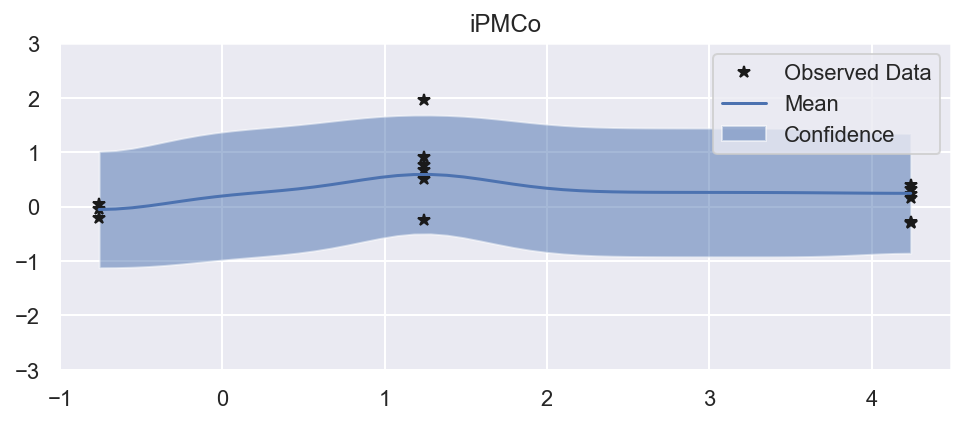

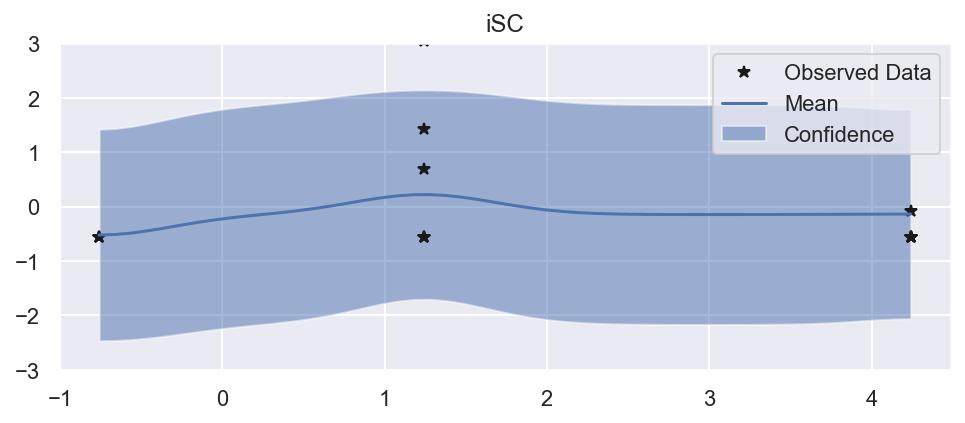

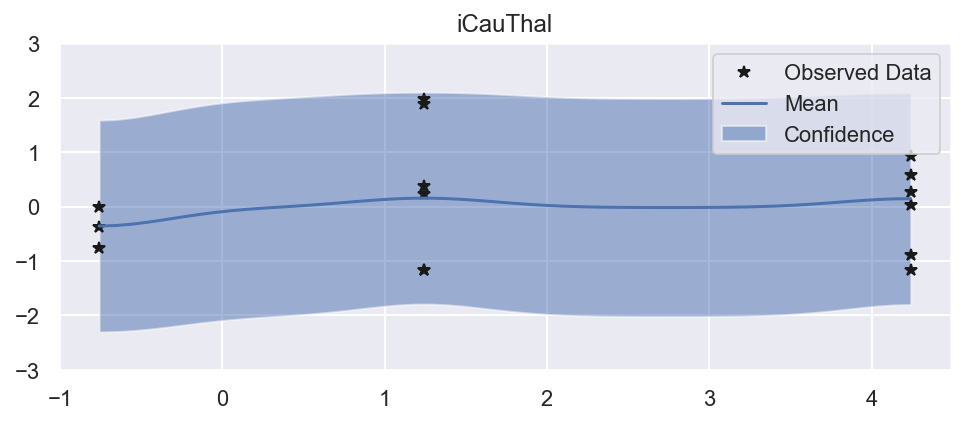

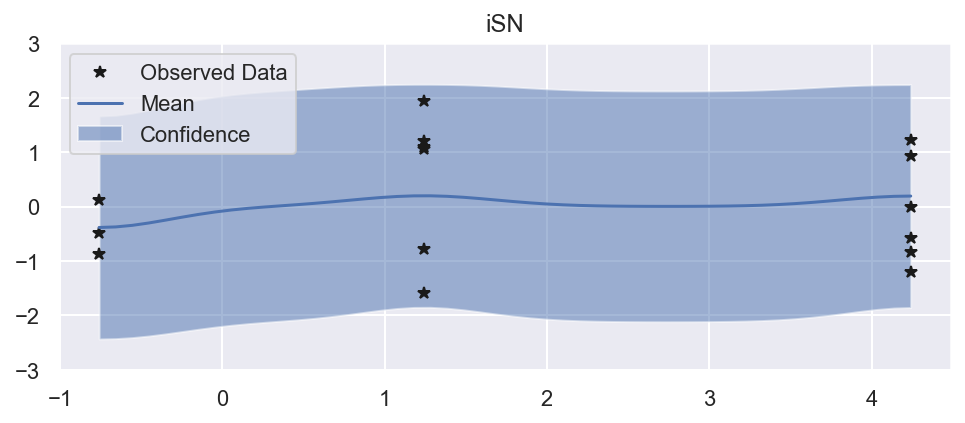

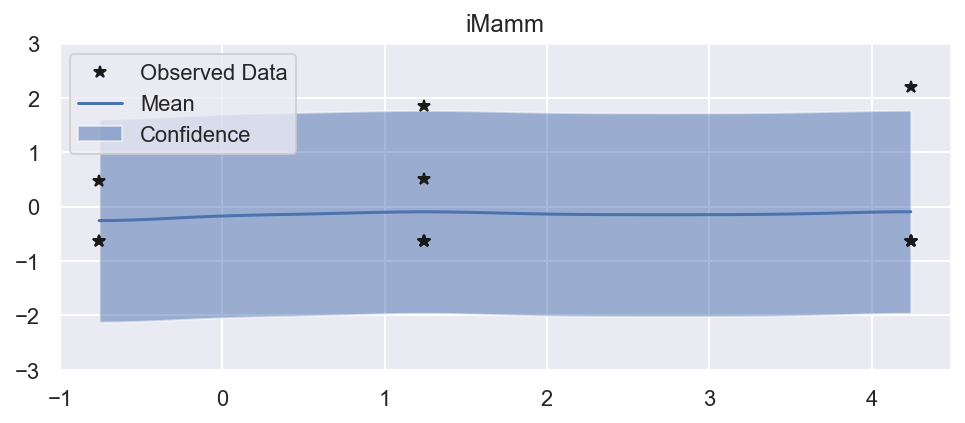

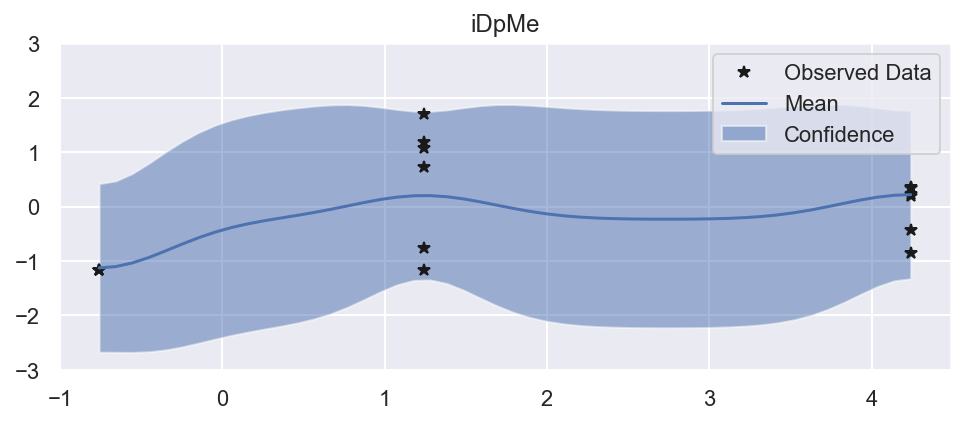

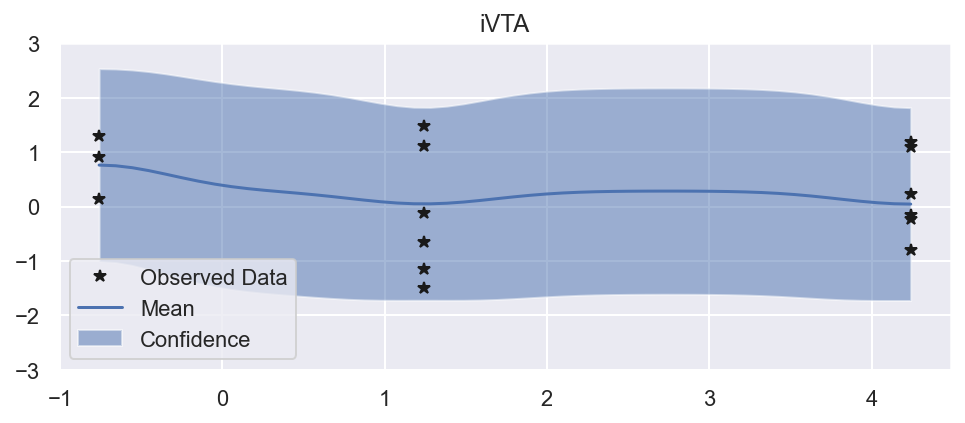

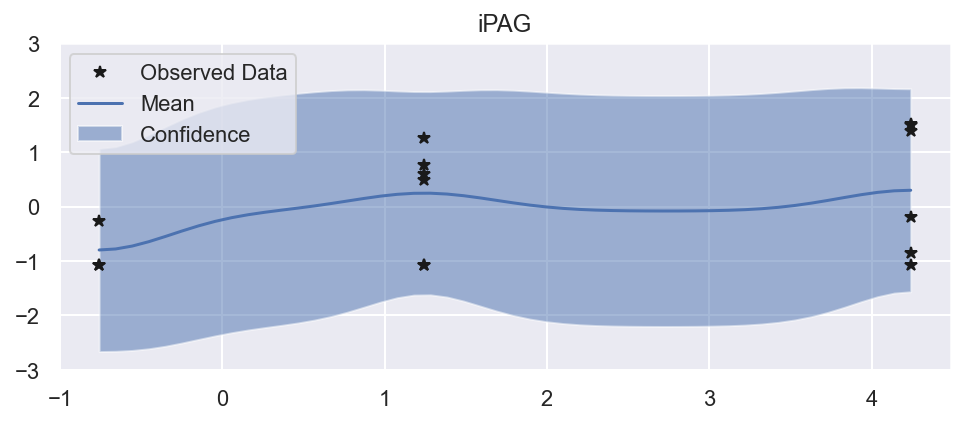

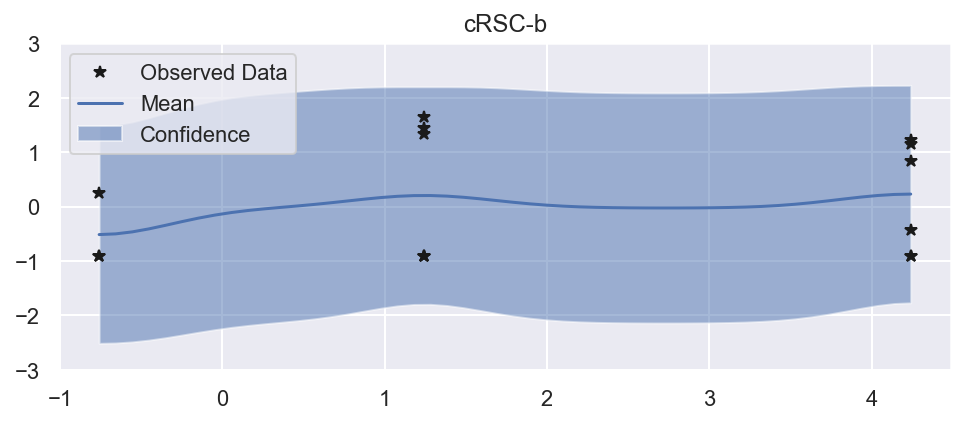

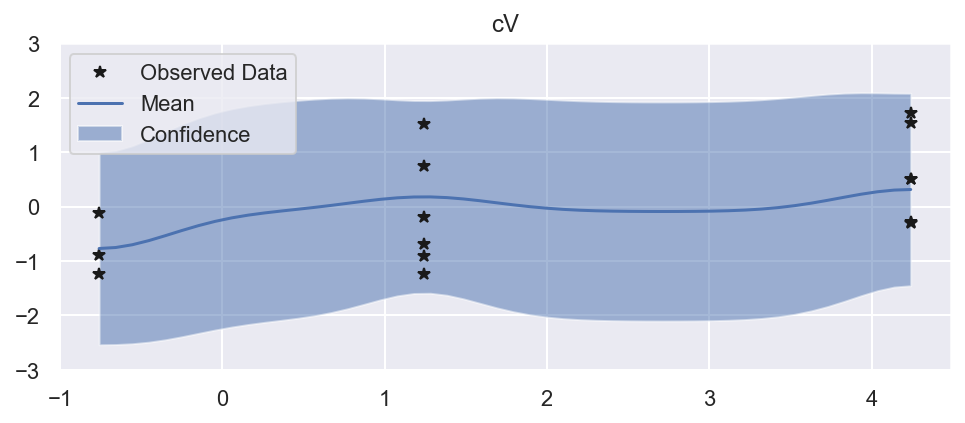

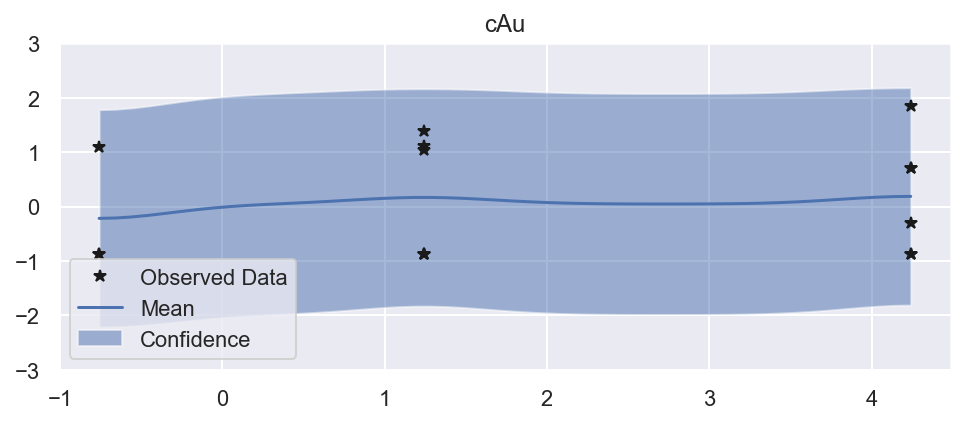

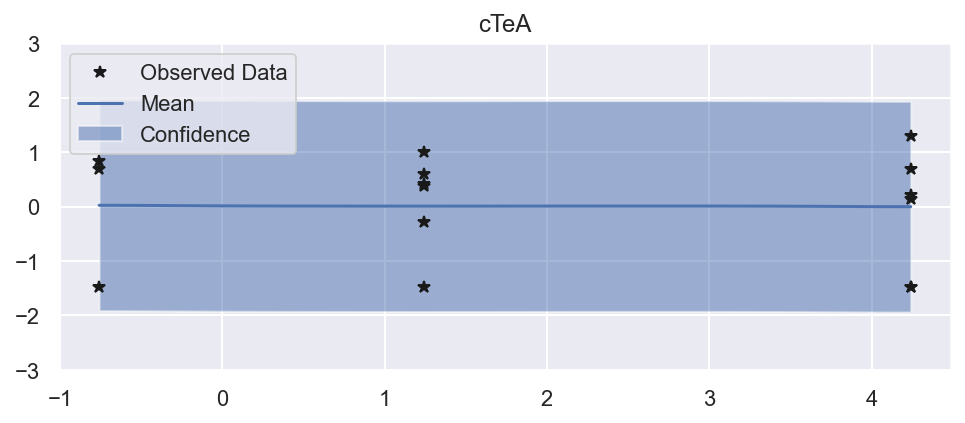

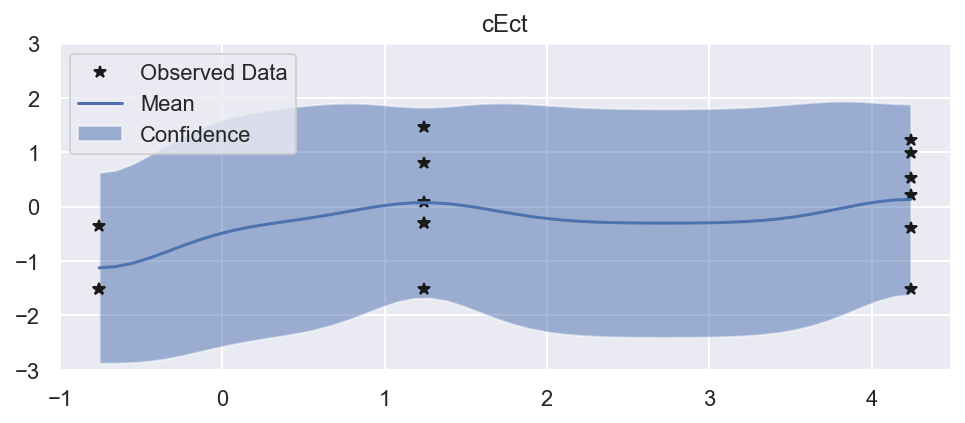

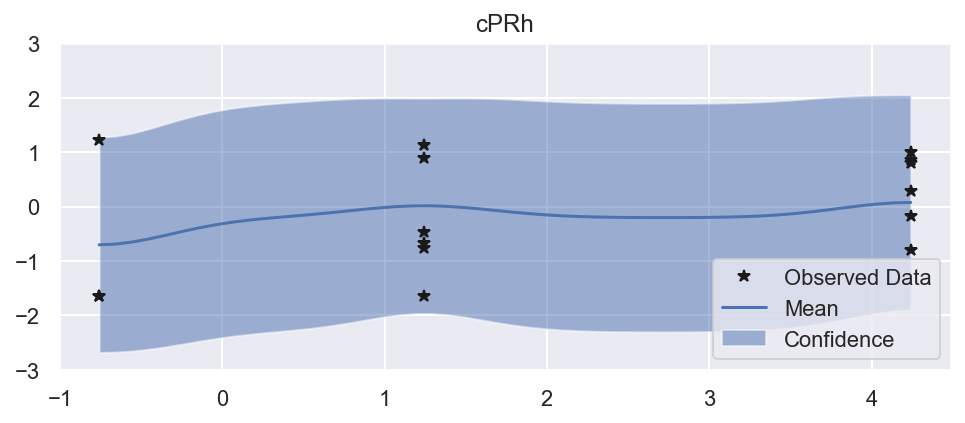

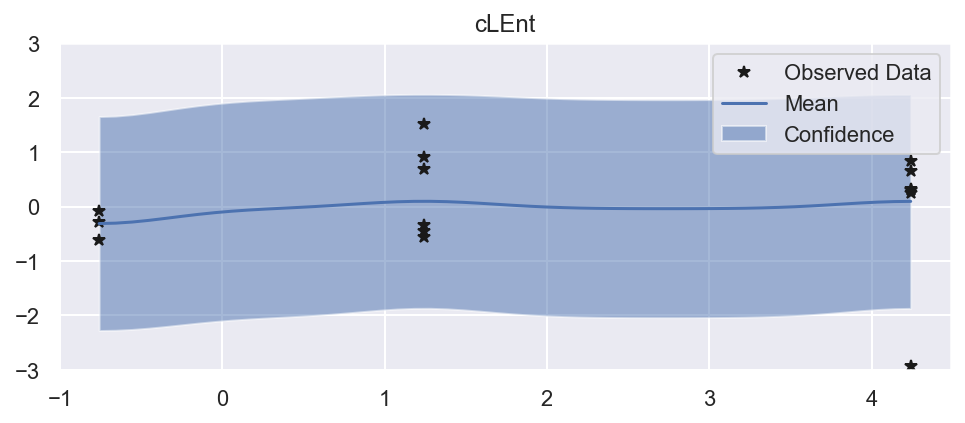

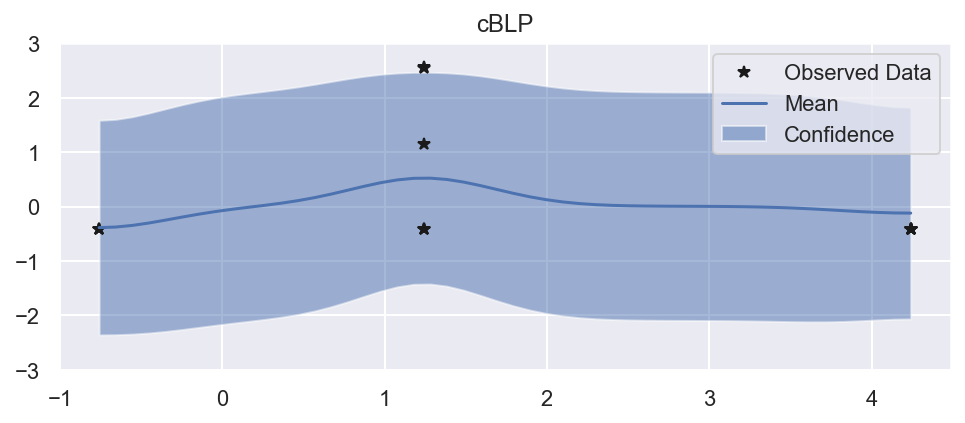

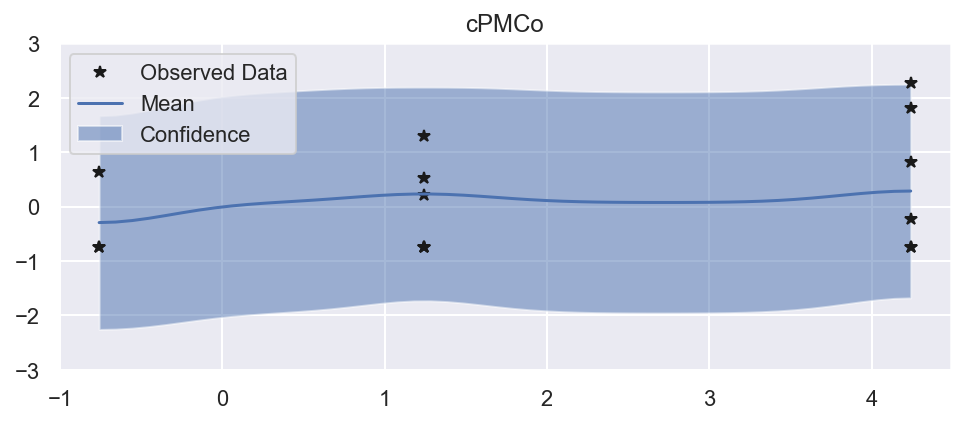

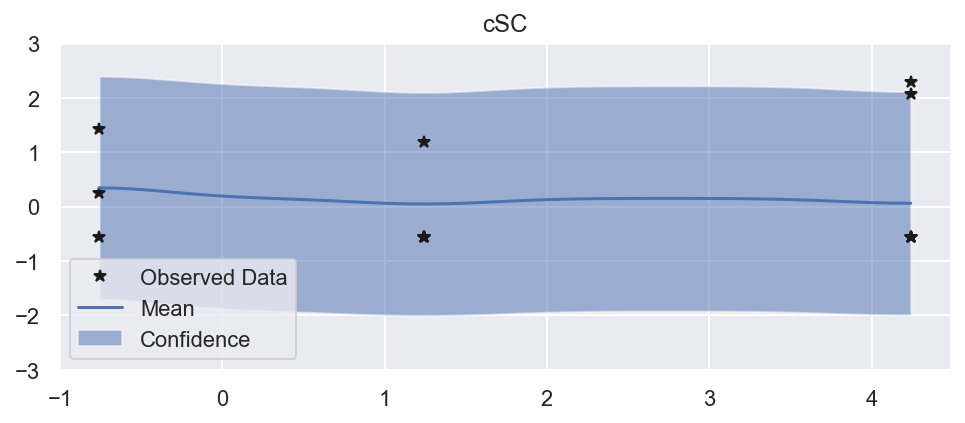

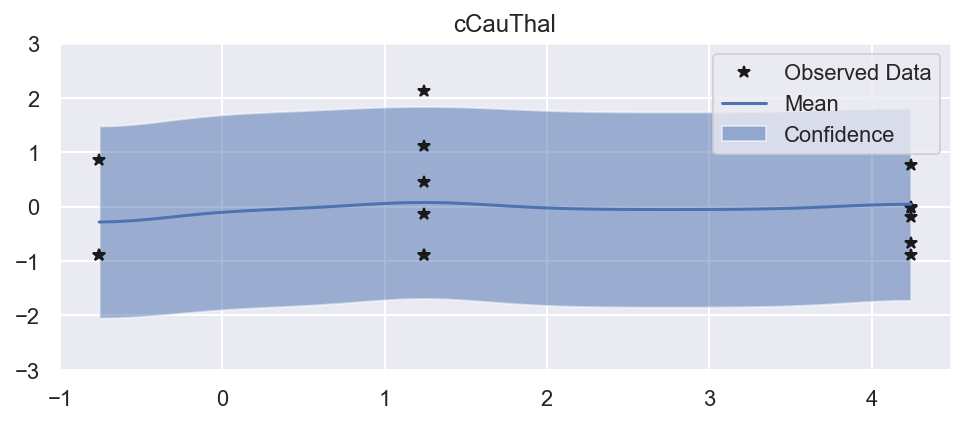

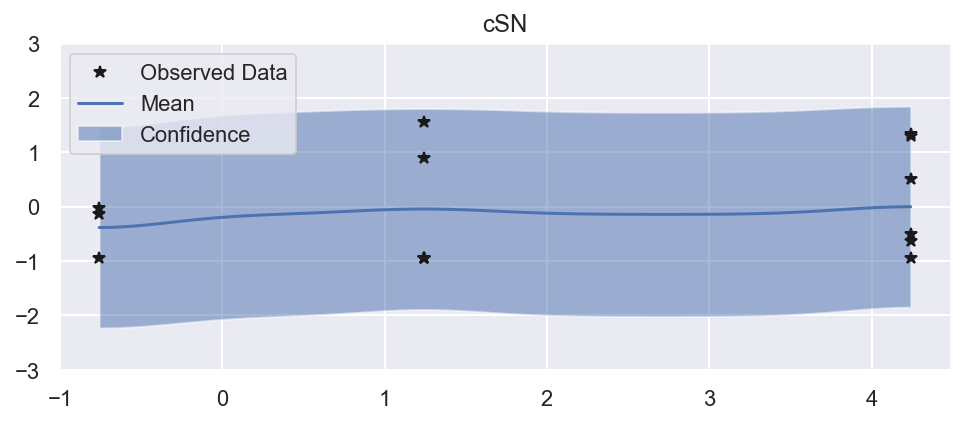

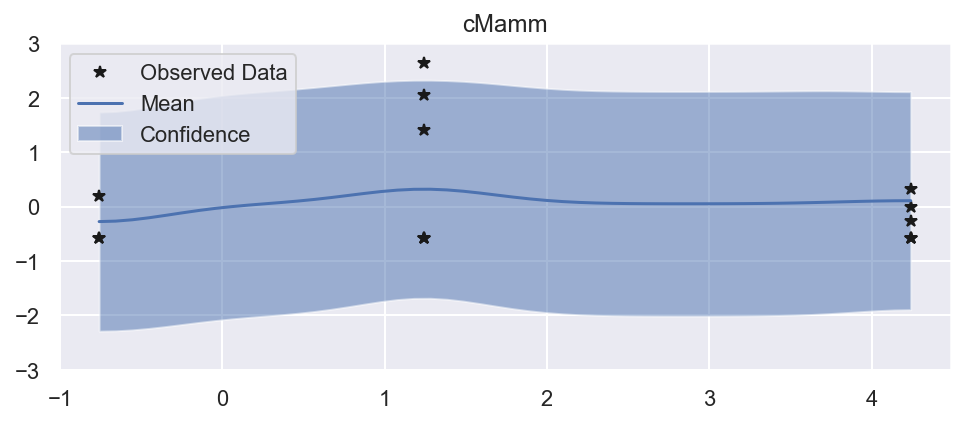

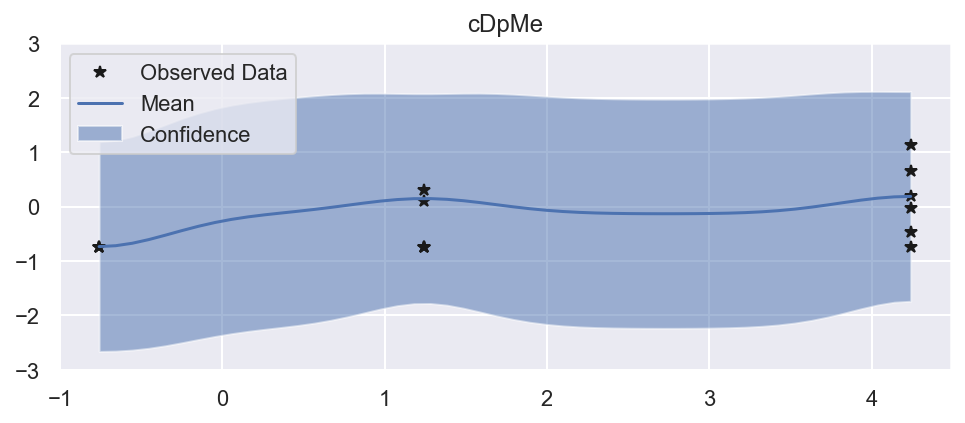

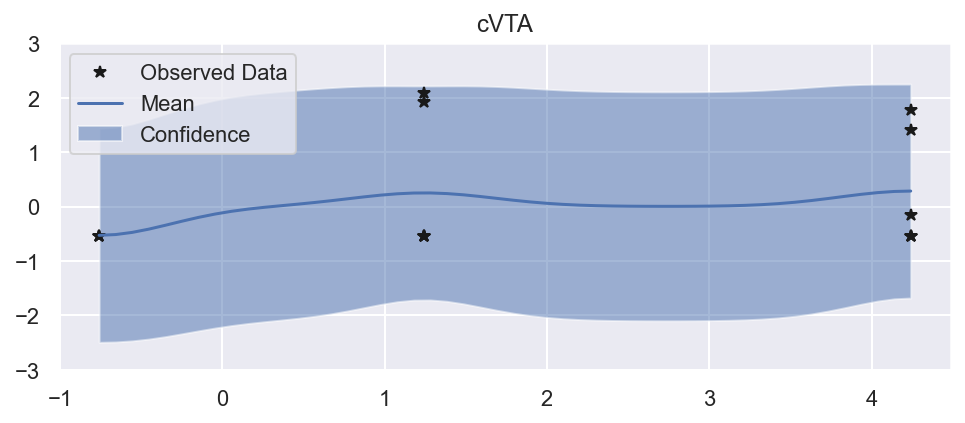

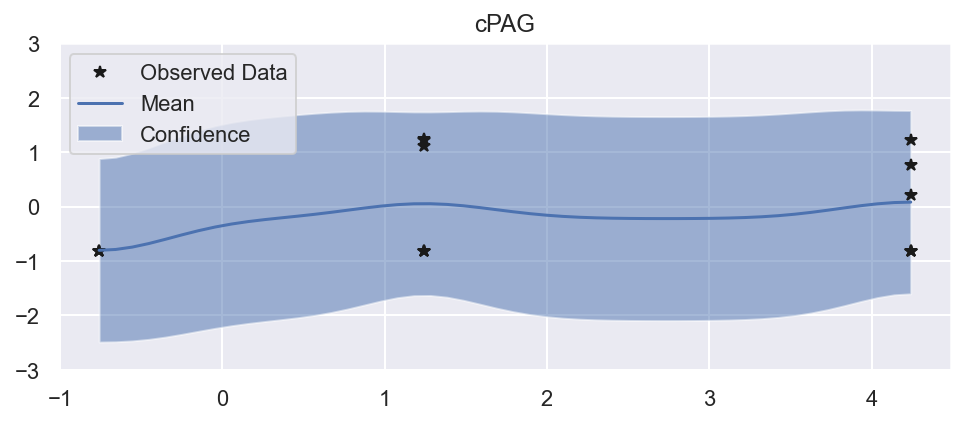

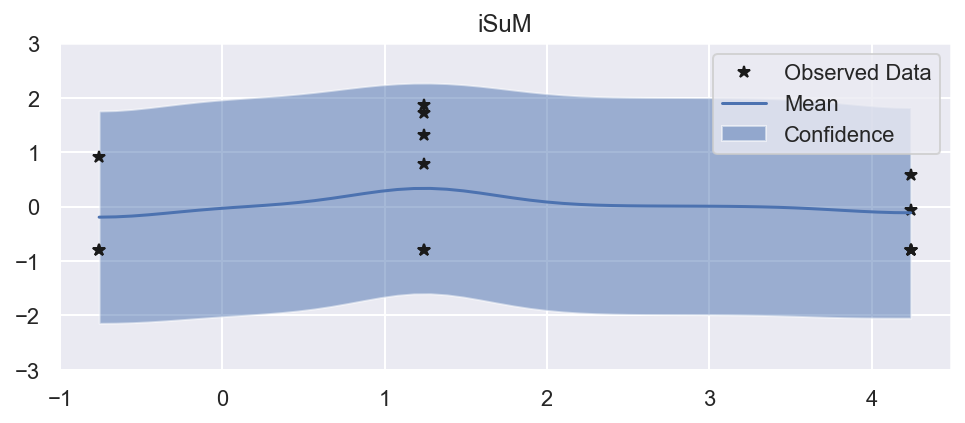

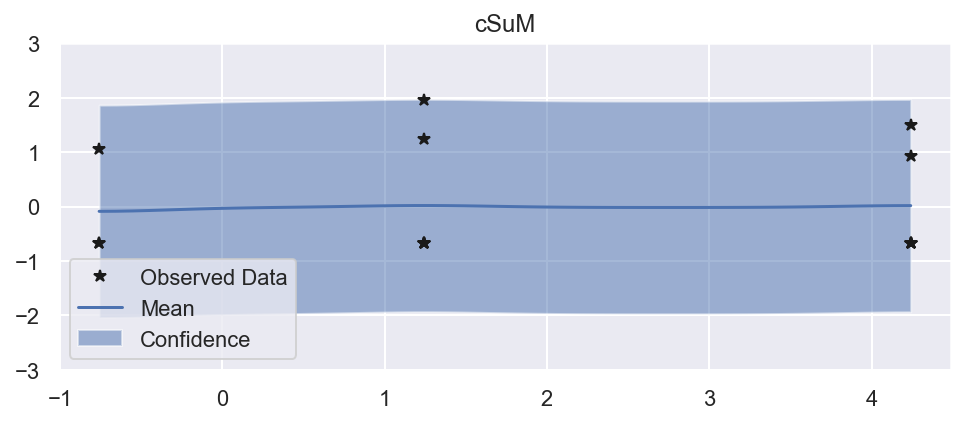

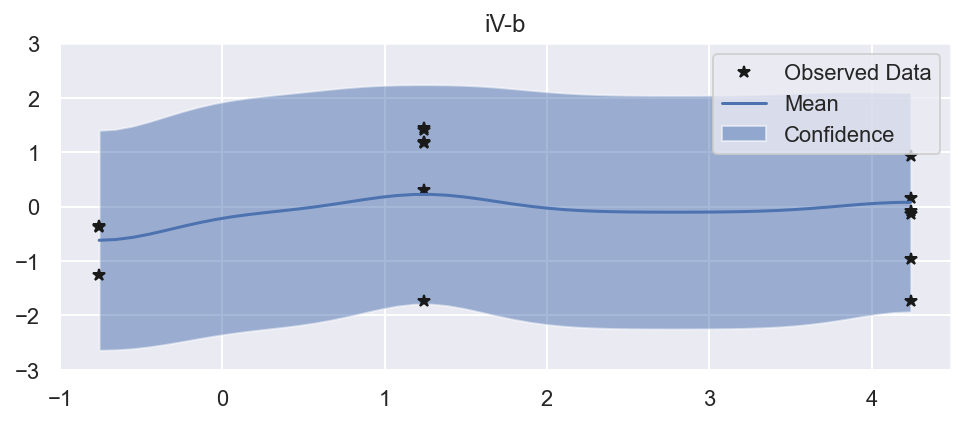

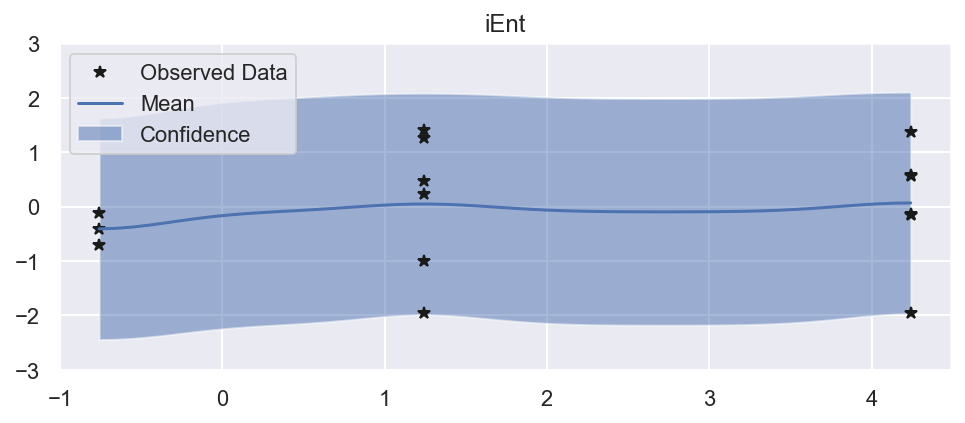

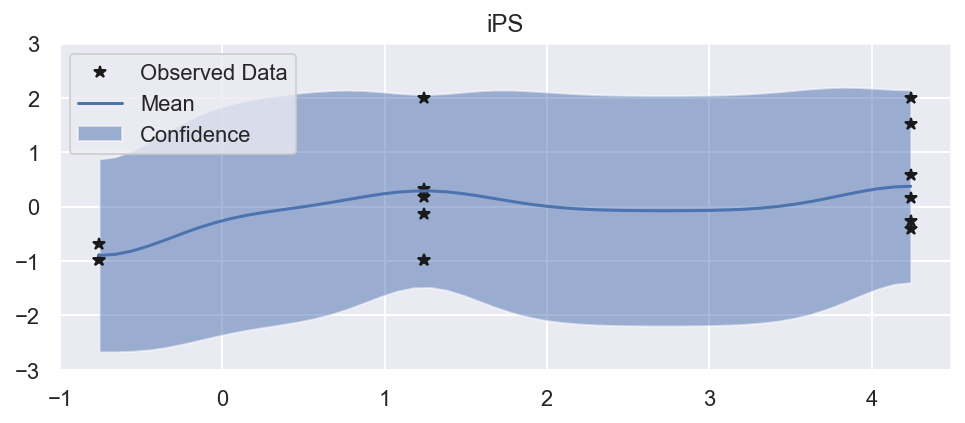

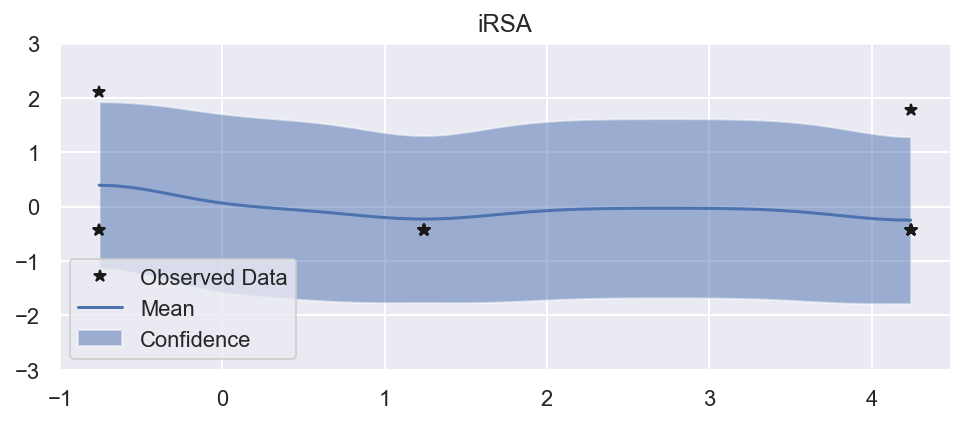

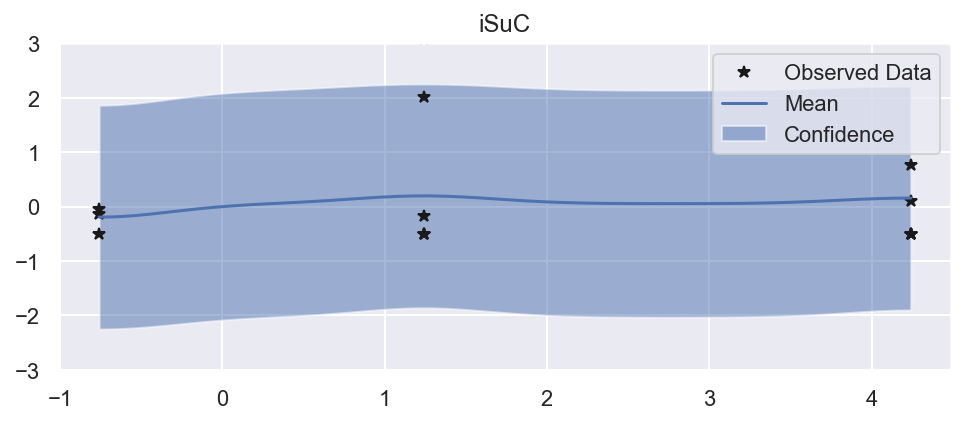

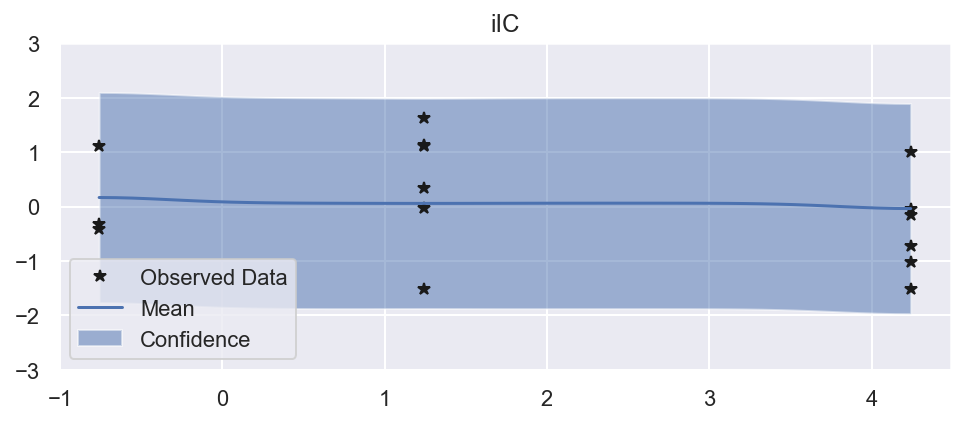

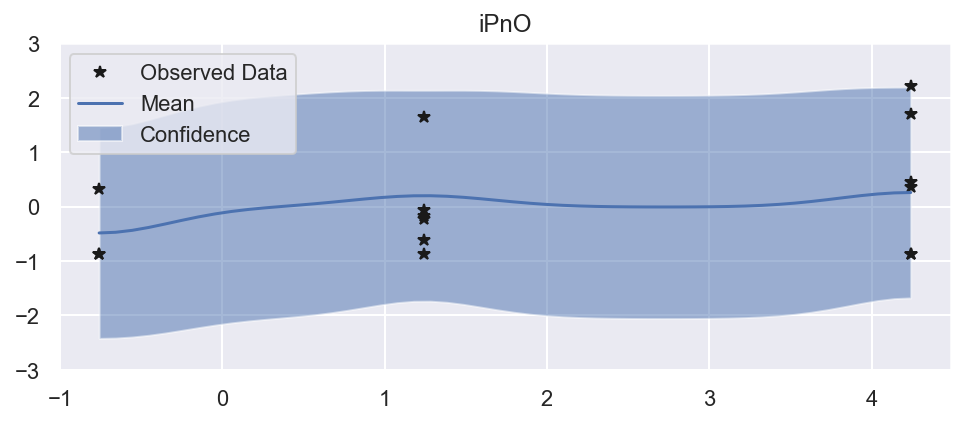

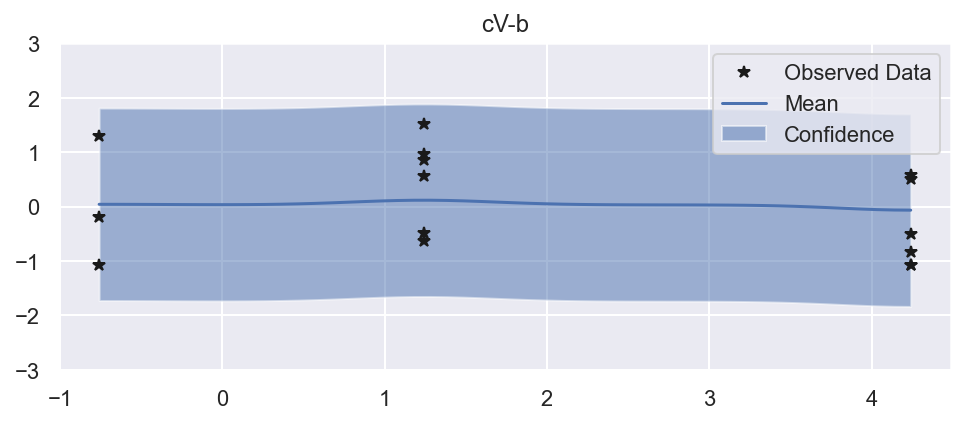

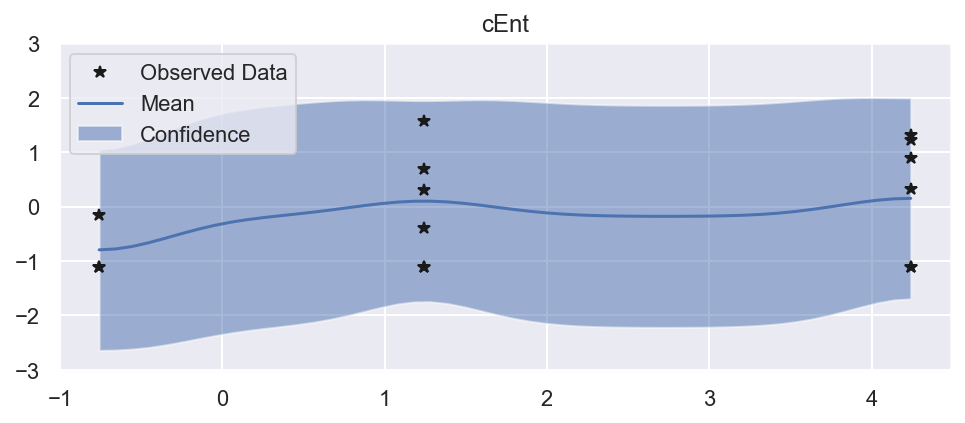

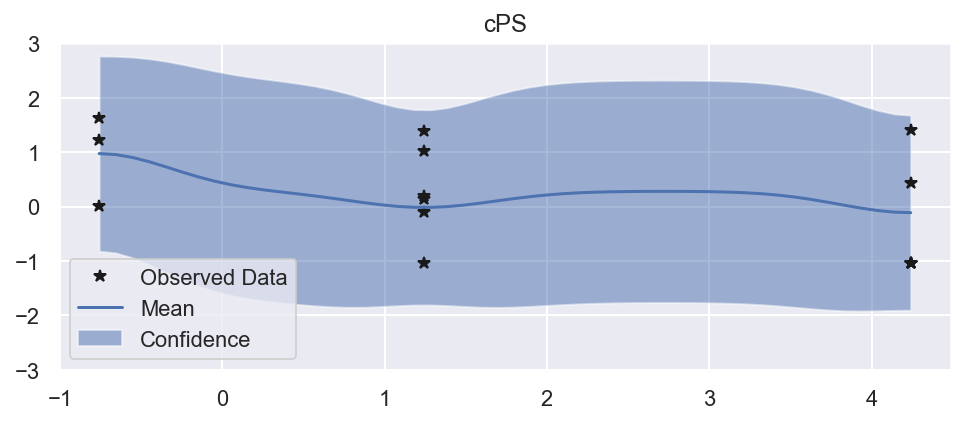

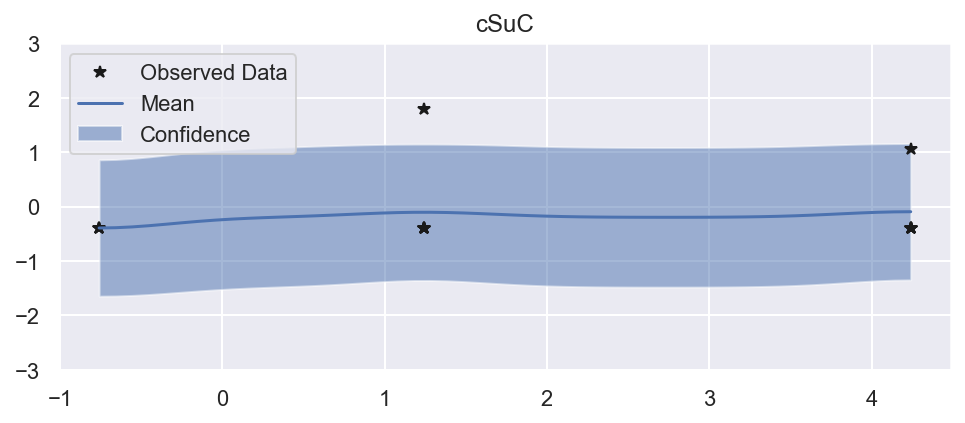

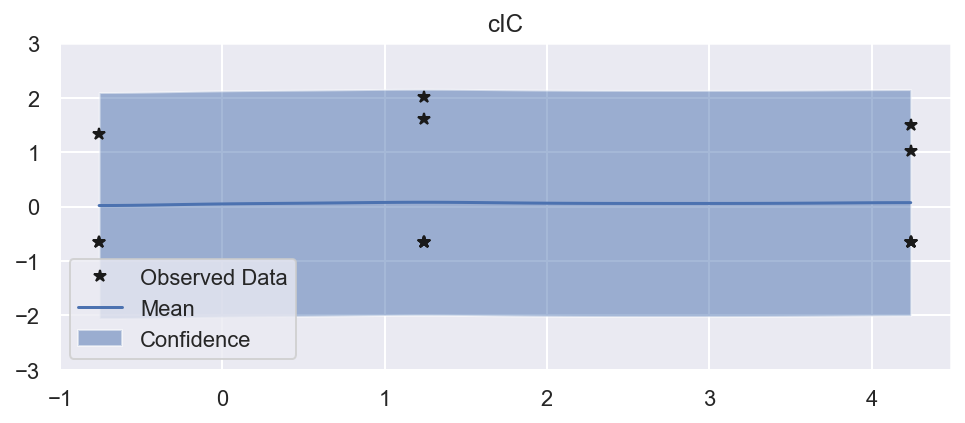

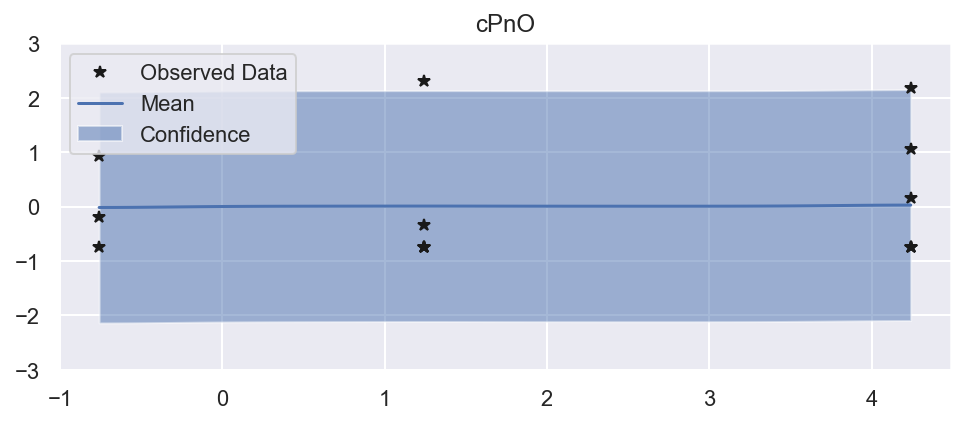

In [32]:
for c in column:
    want_to_see = column.index(c)
    
    # This contains predictions for both tasks, flattened out
    # The first half of the predictions is for the first task
    # The second half is for the second task

    # Initialize plots
    f, ax = plt.subplots(figsize=(8, 3))

    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, want_to_see].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, want_to_see].numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower[:, want_to_see].numpy(), upper[:, want_to_see].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'{c}')
    plt.show()

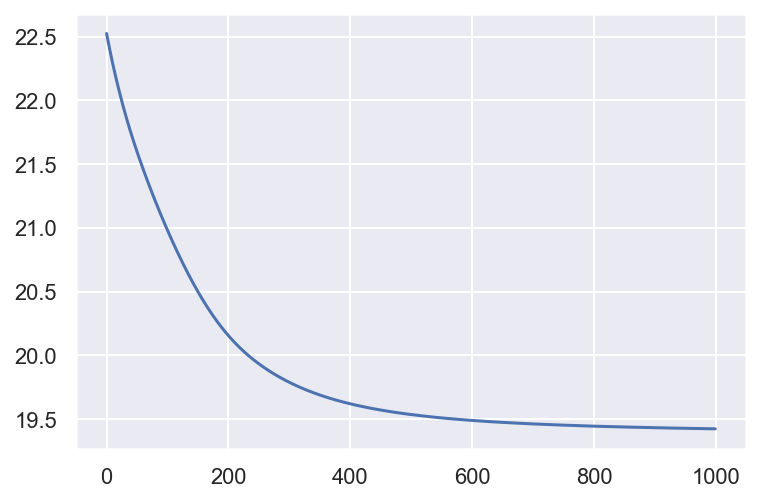

In [34]:
plt.plot(hist_loss);

In [35]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

In [36]:
train_x = torch.rand((16,))
train_y = torch.rand((16, 116))
print(train_x.shape)
print(train_y.shape)
print(train_x.dtype)
print(train_y.dtype)
print(train_x.stride())
print(train_y.stride())

torch.Size([16])
torch.Size([16, 116])
torch.float32
torch.float32
(1,)
(116, 1)
